In [10]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
import pyspark.pandas as ps
from pyspark.sql import SparkSession


def user_details(start_date, end_date,entity_d):

    query = f"""
    WITH listing AS (    
        SELECT   global_entity_id
                ,country
                ,CAST(DATE_TRUNC(injestion_time, MONTH) AS DATE) session_month
                ,CAST(DATE_TRUNC(injestion_time, ISOWEEK) AS DATE) session_week
                ,CAST(DATE_TRUNC(injestion_time, DAY) AS DATE) session_day
                ,EXTRACT(HOUR FROM injestion_time) AS session_hour
                ,session_key 
                ,perseus_session_id
                ,chainId 
                ,shopId
                ,userId
                ,df_impressions 
        FROM (
        SELECT  session_key
                ,COALESCE(pe.global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,userId
                ,ingestion_timestamp injestion_time
                ,country
                ,COALESCE(chainId, JSON_VALUE(eventVariables_json, "$.chainId") ) AS chainId
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY ingestion_timestamp) row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")) df_raw
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'shop_impressions.loaded'
                AND screenType = 'shop_list'
                AND pe.global_entity_id IN (""" + entity_d + """)
                AND locationCity IS NOT NULL
                AND shopType = 'restaurants'
        )
        WHERE row_num = 1
        AND df_raw IS NOT NULL
        ORDER BY global_entity_id, session_key
    ), shop_details AS (
        SELECT  global_entity_id
                ,session_key
                ,perseus_session_id
                ,shopId
                ,df_impressions
        FROM (
        SELECT  session_key
                ,COALESCE(global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY "timestamp") row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'shop_details.loaded'
                AND global_entity_id IN (""" + entity_d + """)
        )
        WHERE row_num = 1
        ORDER BY global_entity_id, session_key
    ), checkout AS (
        SELECT  global_entity_id
                ,session_key
                ,perseus_session_id
                ,shopId
                ,df_impressions
        FROM (
        SELECT  session_key
                ,COALESCE(global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY "timestamp") row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'checkout.loaded'
                AND global_entity_id IN (""" + entity_d + """)
        )
        WHERE row_num = 1
        ORDER BY global_entity_id, session_key
    ), orders AS (
        SELECT  global_entity_id
                ,session_key
                ,perseus_session_id
                ,shopId
                ,df_impressions
        FROM (
        SELECT  session_key
                ,COALESCE(global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY "timestamp") row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction IN ('transaction')
                AND global_entity_id IN (""" + entity_d + """)
        )
        WHERE row_num = 1
        ORDER BY global_entity_id, session_key
    ), rates AS (
        SELECT cu.country_iso
            ,cu.currency_code
            ,tmp.fx_rate_eur
        FROM `fulfillment-dwh-production.cl.countries` cu
        JOIN ( 
            WITH latest_fx_rate AS (
            SELECT 
                currency_code,
                fx_rate_eur,
                calculated_at,
                ROW_NUMBER() OVER (PARTITION BY currency_code ORDER BY calculated_at DESC) AS rn
            FROM `fulfillment-dwh-production.curated_data_shared_coredata.fx_rates`
            )
            SELECT 
                currency_code,
                fx_rate_eur,
                calculated_at AS max_calculated_at
            FROM latest_fx_rate
            WHERE rn = 1
        ) tmp ON tmp.currency_code = cu.currency_code
        GROUP BY 1, 2, 3
        ORDER BY 1
    )
    SELECT      l.global_entity_id
                ,l.userId
                -- Delivery fee listing calculations
                ,AVG(l.df_impressions / r.fx_rate_eur) AS delivery_fee_listing_eur_mean
                ,APPROX_QUANTILES(l.df_impressions / r.fx_rate_eur, 100)[OFFSET(50)] AS delivery_fee_listing_eur_median
                ,MIN(l.df_impressions / r.fx_rate_eur) AS delivery_fee_listing_eur_min
                ,MAX(l.df_impressions / r.fx_rate_eur) AS delivery_fee_listing_eur_max
                ,STDDEV(l.df_impressions / r.fx_rate_eur) AS delivery_fee_listing_eur_stddev
                
                -- Delivery fee details page calculations
                ,AVG(sd.df_impressions / r.fx_rate_eur) AS delivery_fee_details_eur_mean
                ,APPROX_QUANTILES(sd.df_impressions / r.fx_rate_eur, 100)[OFFSET(50)] AS delivery_fee_details_eur_median
                ,MIN(sd.df_impressions / r.fx_rate_eur) AS delivery_fee_details_eur_min
                ,MAX(sd.df_impressions / r.fx_rate_eur) AS delivery_fee_details_eur_max
                ,STDDEV(sd.df_impressions / r.fx_rate_eur) AS delivery_fee_details_eur_stddev
                
                -- Delivery fee checkout calculations
                ,AVG(co.df_impressions / r.fx_rate_eur) AS delivery_fee_checkout_eur_mean
                ,APPROX_QUANTILES(co.df_impressions / r.fx_rate_eur, 100)[OFFSET(50)] AS delivery_fee_checkout_eur_median
                ,MIN(co.df_impressions / r.fx_rate_eur) AS delivery_fee_checkout_eur_min
                ,MAX(co.df_impressions / r.fx_rate_eur) AS delivery_fee_checkout_eur_max
                ,STDDEV(co.df_impressions / r.fx_rate_eur) AS delivery_fee_checkout_eur_stddev
                
                -- Delivery fee order calculations
                ,AVG(o.df_impressions / r.fx_rate_eur) AS delivery_fee_order_eur_mean
                ,APPROX_QUANTILES(o.df_impressions / r.fx_rate_eur, 100)[OFFSET(50)] AS delivery_fee_order_eur_median
                ,MIN(o.df_impressions / r.fx_rate_eur) AS delivery_fee_order_eur_min
                ,MAX(o.df_impressions / r.fx_rate_eur) AS delivery_fee_order_eur_ma
                ,STDDEV(o.df_impressions / r.fx_rate_eur) AS delivery_fee_order_eur_stddev
                ,COUNT(l.shopId) AS total_vendor
                ,SUM(CASE WHEN sd.shopId IS NOT NULL THEN 1 ELSE 0 END) AS converted_details_page
                ,SUM(CASE WHEN co.shopId IS NOT NULL THEN 1 ELSE 0 END) AS converted_checkout
                ,SUM(CASE WHEN o.shopId IS NOT NULL THEN 1 ELSE 0 END) AS converted_order
    FROM listing l
    LEFT JOIN shop_details sd ON sd.global_entity_id = l.global_entity_id AND sd.session_key = l.session_key AND sd.shopId = l.shopId
    LEFT JOIN checkout co ON co.global_entity_id = l.global_entity_id AND co.session_key = l.session_key AND co.shopId = l.shopId
    LEFT JOIN orders o ON o.global_entity_id = l.global_entity_id AND o.session_key = l.session_key AND o.shopId = l.shopId
    LEFT JOIN rates r ON l.country = r.country_iso
    GROUP BY 1, 2
    """

    return query



def user_conversion(start_date, end_date,entity_d):

    query = f"""
    WITH listing AS (    
        SELECT   global_entity_id
                ,country
                ,CAST(DATE_TRUNC(injestion_time, MONTH) AS DATE) session_month
                ,CAST(DATE_TRUNC(injestion_time, ISOWEEK) AS DATE) session_week
                ,CAST(DATE_TRUNC(injestion_time, DAY) AS DATE) session_day
                ,EXTRACT(HOUR FROM injestion_time) AS session_hour
                ,session_key 
                ,perseus_session_id
                ,chainId 
                ,shopId
                ,userId
                ,df_impressions 
        FROM (
        SELECT  session_key
                ,COALESCE(pe.global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,userId
                ,ingestion_timestamp injestion_time
                ,country
                ,COALESCE(chainId, JSON_VALUE(eventVariables_json, "$.chainId") ) AS chainId
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY ingestion_timestamp) row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")) df_raw
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'shop_impressions.loaded'
                AND screenType = 'shop_list'
                AND pe.global_entity_id IN (""" + entity_d + """)
                AND locationCity IS NOT NULL
                AND shopType = 'restaurants'
        )
        WHERE row_num = 1
        AND df_raw IS NOT NULL
        ORDER BY global_entity_id, session_key
    ), shop_details AS (
        SELECT  global_entity_id
                ,session_key
                ,perseus_session_id
                ,shopId
                ,df_impressions
        FROM (
        SELECT  session_key
                ,COALESCE(global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY "timestamp") row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'shop_details.loaded'
                AND global_entity_id IN (""" + entity_d + """)
        )
        WHERE row_num = 1
        ORDER BY global_entity_id, session_key
    ), checkout AS (
        SELECT  global_entity_id
                ,session_key
                ,perseus_session_id
                ,shopId
                ,df_impressions
        FROM (
        SELECT  session_key
                ,COALESCE(global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY "timestamp") row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'checkout.loaded'
                AND global_entity_id IN (""" + entity_d + """)
        )
        WHERE row_num = 1
        ORDER BY global_entity_id, session_key
    ), orders AS (
        SELECT  global_entity_id
                ,session_key
                ,perseus_session_id
                ,shopId
                ,df_impressions
        FROM (
        SELECT  session_key
                ,COALESCE(global_entity_id, JSON_VALUE(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key, shopId ORDER BY "timestamp") row_num
                ,COALESCE(shopId, JSON_VALUE(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(CAST(NULLIF(REGEXP_EXTRACT(COALESCE(JSON_VALUE(eventVariables_json, "$.vendorDeliveryFee"), JSON_VALUE(eventVariables_json, "$.shopDeliveryFee")), r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64), 0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction IN ('transaction')
                AND global_entity_id IN (""" + entity_d + """)
        )
        WHERE row_num = 1
        ORDER BY global_entity_id, session_key
    ), rates AS (
        SELECT cu.country_iso
            ,cu.currency_code
            ,tmp.fx_rate_eur
        FROM `fulfillment-dwh-production.cl.countries` cu
        JOIN ( 
            WITH latest_fx_rate AS (
            SELECT 
                currency_code,
                fx_rate_eur,
                calculated_at,
                ROW_NUMBER() OVER (PARTITION BY currency_code ORDER BY calculated_at DESC) AS rn
            FROM `fulfillment-dwh-production.curated_data_shared_coredata.fx_rates`
            )
            SELECT 
                currency_code,
                fx_rate_eur,
                calculated_at AS max_calculated_at
            FROM latest_fx_rate
            WHERE rn = 1
        ) tmp ON tmp.currency_code = cu.currency_code
        GROUP BY 1, 2, 3
        ORDER BY 1
    ), impression as (
    SELECT       l.global_entity_id
                ,l.country
                ,l.userId
                ,ROUND((l.df_impressions / r.fx_rate_eur) * 5) / 5 AS delivery_fee_listing
                ,ROUND((sd.df_impressions / r.fx_rate_eur) * 5) / 5 AS delivery_fee_details
                ,ROUND((co.df_impressions / r.fx_rate_eur) * 5) / 5 AS delivery_fee_checkout
                ,COUNT(l.shopId) AS total_vendor
                ,SUM(CASE WHEN sd.shopId IS NOT NULL THEN 1 ELSE 0 END) AS converted_details_page
                ,SUM(CASE WHEN co.shopId IS NOT NULL THEN 1 ELSE 0 END) AS converted_checkout
                ,SUM(CASE WHEN o.shopId IS NOT NULL THEN 1 ELSE 0 END) AS converted_order
                ,SUM(CASE WHEN sd.shopId IS NOT NULL THEN 1 ELSE 0 END) / COUNT(l.shopId) conversion_details
                ,SUM(CASE WHEN co.shopId IS NOT NULL THEN 1 ELSE 0 END) / COUNT(l.shopId) conversion_checkout
                ,SUM(CASE WHEN o.shopId IS NOT NULL THEN 1 ELSE 0 END) / COUNT(l.shopId) conversion_order
    FROM listing l
    LEFT JOIN shop_details sd ON sd.global_entity_id = l.global_entity_id AND sd.session_key = l.session_key AND sd.shopId = l.shopId
    LEFT JOIN checkout co ON co.global_entity_id = l.global_entity_id AND co.session_key = l.session_key AND co.shopId = l.shopId
    LEFT JOIN orders o ON o.global_entity_id = l.global_entity_id AND o.session_key = l.session_key AND o.shopId = l.shopId
    LEFT JOIN rates r ON l.country = r.country_iso
    GROUP BY 1, 2, 3, 4, 5, 6
    )
    select * 
    from (
    select  global_entity_id
        ,delivery_fee_listing
        ,delivery_fee_details
        ,delivery_fee_checkout
        ,avg(conversion_details) avg_conversion_details
        ,avg(conversion_checkout) avg_conversion_checkout
        ,avg(conversion_order) avg_conversion_order
        ,sum(total_vendor) vendors
        ,count(distinct userId) total_users
        ,count(distinct case when converted_details_page > 0 then userId end) converted_user_count_details
        ,count(distinct case when converted_checkout > 0 then userId end) converted_user_count_checkout
        ,count(distinct case when converted_order > 0 then userId end) converted_user_count_order
    FROM impression
    group by 1,2,3,4
    order by 1,2
    )
    
    where vendors > 100
    """

    return query


# def user_conversion_funnel(df):
    
#     for i in df['global_entity_id'].unique():

#         df_tmp = df[df['global_entity_id'] == i]

#         # Groupby and aggregate data for conversion counts
#         user_conversion = df_tmp.groupby(['global_entity_id']).agg(
#             converted_user_count_order=('userId', lambda x: x[df_tmp['converted_order'] > 0].nunique()),
#             converted_user_count_details=('userId', lambda x: x[df_tmp['converted_details_page'] > 0].nunique()),
#             converted_user_count_checkout=('userId', lambda x: x[df_tmp['converted_checkout'] > 0].nunique()),
#             total_user_count=('userId', 'nunique')
#         ).reset_index()

#         # Calculate funnel metrics
#         user_conversion['user_listing'] = user_conversion['total_user_count'] / user_conversion['total_user_count']
#         user_conversion['user_listing_to_details'] = user_conversion['converted_user_count_details'] / user_conversion['total_user_count']
#         user_conversion['user_listing_to_checkout'] = user_conversion['converted_user_count_checkout'] / user_conversion['total_user_count']
#         user_conversion['user_listing_to_transaction'] = user_conversion['converted_user_count_order'] / user_conversion['total_user_count']

    
#         # List of conversion stages
#         lst = [
#         round(user_conversion['user_listing'][0] * 100, 0),  # Convert to percentage and round
#         round(user_conversion['user_listing_to_details'][0] * 100, 0),
#         round(user_conversion['user_listing_to_checkout'][0] * 100, 0),
#         round(user_conversion['user_listing_to_transaction'][0] * 100, 0)
#         ]

#         # Data for funnel plot
#         funnel_data = dict(
#             number=lst,
#             stage=["Listing", "Listing_to_details", "Listing_to_checkout", "Listing_to_transaction"]
#         )

#         # Create funnel plot using plotly
#         fig = px.funnel(funnel_data, x='number', y='stage')
#         fig.update_layout(title='User conversion ' + i, width=750,height=400)
#         fig.show()

def user_conversion_funnel(df):
    
    # Create a list to store data for all entities
    funnel_data_list = []
    
    for i in df['global_entity_id'].unique():

        df_tmp = df[df['global_entity_id'] == i]

        # Groupby and aggregate data for conversion counts
        user_conversion = df_tmp.groupby(['global_entity_id']).agg(
            converted_user_count_order=('userId', lambda x: x[df_tmp['converted_order'] > 0].nunique()),
            converted_user_count_details=('userId', lambda x: x[df_tmp['converted_details_page'] > 0].nunique()),
            converted_user_count_checkout=('userId', lambda x: x[df_tmp['converted_checkout'] > 0].nunique()),
            total_user_count=('userId', 'nunique')
        ).reset_index()

        # Calculate funnel metrics
        user_conversion['user_listing'] = user_conversion['total_user_count'] / user_conversion['total_user_count']
        user_conversion['user_listing_to_details'] = user_conversion['converted_user_count_details'] / user_conversion['total_user_count']
        user_conversion['user_listing_to_checkout'] = user_conversion['converted_user_count_checkout'] / user_conversion['total_user_count']
        user_conversion['user_listing_to_transaction'] = user_conversion['converted_user_count_order'] / user_conversion['total_user_count']

        # Append the conversion stages for the current entity to the list
        funnel_data_list.append({
            'global_entity_id': i,
            'stage': 'Listing',
            'conversion_rate': round(user_conversion['user_listing'][0] * 100, 0)
        })
        funnel_data_list.append({
            'global_entity_id': i,
            'stage': 'Listing_to_details',
            'conversion_rate': round(user_conversion['user_listing_to_details'][0] * 100, 0)
        })
        funnel_data_list.append({
            'global_entity_id': i,
            'stage': 'Listing_to_checkout',
            'conversion_rate': round(user_conversion['user_listing_to_checkout'][0] * 100, 0)
        })
        funnel_data_list.append({
            'global_entity_id': i,
            'stage': 'Listing_to_transaction',
            'conversion_rate': round(user_conversion['user_listing_to_transaction'][0] * 100, 0)
        })

    # Create a DataFrame from the list
    funnel_data_df = pd.DataFrame(funnel_data_list)

    # Create a funnel plot for all entities
    fig = px.funnel(funnel_data_df, x='conversion_rate', y='stage', color='global_entity_id')
    fig.update_layout(title='User Conversion Funnel Across Entities', width=800, height=600)
    fig.show()


def plot_delivery_fee_boxplot(df, column_list):
    
    for i in df['global_entity_id'].unique():
        
        df_tmp = df[df['global_entity_id'] == i]
        
        if not all(col in df_tmp.columns for col in column_list):
            raise ValueError(f"Some columns in {column_list} do not exist in the DataFrame for entity {i}")
        
        stage_mapping = {col: col.split('_')[2].capitalize() if len(col.split('_')) > 2 else col for col in column_list}
        
        delivery_fee_mean = df_tmp[column_list]
        
        df_melted = delivery_fee_mean.melt(var_name='Stage', value_name='Delivery Fee (EUR)')
        
        df_melted['Stage'] = df_melted['Stage'].replace(stage_mapping)
        
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df_melted, x='Stage', y='Delivery Fee (EUR)')
        
        plt.title(f'{i} Delivery Fees Across Different Stages', fontsize=16)
        
        plt.show()

def descriptive_stats(df):
    # Group the data by 'global_entity_id'
    grouped = df.groupby('global_entity_id') 

    # Create an empty dictionary to store the descriptive statistics
    grouped_descriptive_stats = {}

    # Define the manual order for sorting
    manual_order = [
        'delivery_fee_listing_eur_mean', 'delivery_fee_details_eur_mean', 'delivery_fee_checkout_eur_mean', 'delivery_fee_order_eur_mean',
        'delivery_fee_listing_eur_median', 'delivery_fee_details_eur_median', 'delivery_fee_checkout_eur_median', 'delivery_fee_order_eur_median',
        'delivery_fee_listing_eur_min', 'delivery_fee_details_eur_min', 'delivery_fee_checkout_eur_min', 'delivery_fee_order_eur_min',
        'delivery_fee_listing_eur_max', 'delivery_fee_details_eur_max', 'delivery_fee_checkout_eur_max', 'delivery_fee_order_eur_ma',
        'delivery_fee_listing_eur_stddev', 'delivery_fee_details_eur_stddev', 'delivery_fee_checkout_eur_stddev', 'delivery_fee_order_eur_stddev',
        'total_vendor', 'converted_details_page', 'converted_checkout', 'converted_order'
    ]

    # Loop through each group and calculate descriptive statistics
    for name, group in grouped:
        descriptive_stats = group.describe().transpose()

        # Reorder the DataFrame based on the manual order
        descriptive_stats = descriptive_stats.reindex(manual_order)

        # Style the descriptive statistics for better readability
        styled = descriptive_stats.style \
                        .format(precision=2, thousands=",", decimal=".") \
                        .format_index(str.upper, axis=1)
        
        grouped_descriptive_stats[name] = styled

    # Display each sorted group's styled descriptive statistics
    for name, styled_df in grouped_descriptive_stats.items():
        print(f"Group: {name}")
        display(styled_df)


def plot_entity_kde(df, delivery_fee_column, threshold=10, num_cols=4):
    """
    Plots a grid of KDE plots for each unique entity in the dataset filtered by a delivery fee threshold.
    
    Parameters:
    user_summary_df (pd.DataFrame): The DataFrame containing the data.
    delivery_fee_column (str): The column name for delivery fee to plot the KDE.
    threshold (float, optional): The threshold for filtering the delivery fees. Default is 10.
    num_cols (int, optional): Number of columns in the grid. Default is 4.
    
    Returns:
    None: Displays the KDE plots for each entity.
    """
    # Filter the dataset where the delivery fee is less than the specified threshold
    filtered_df = df[df[delivery_fee_column] < threshold]

    # Get the unique entity IDs
    entities = filtered_df['global_entity_id'].unique()

    # Define the number of rows for the grid based on the number of entities and columns
    num_entities = len(entities)
    num_rows = math.ceil(num_entities / num_cols)

    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each entity and plot a KDE for its values
    for i, entity in enumerate(entities):
        subset = filtered_df[filtered_df['global_entity_id'] == entity]  # Filter data for each entity
        
        # Plot KDE for the entity on the corresponding subplot
        sns.kdeplot(subset[delivery_fee_column], label=f'Entity {entity}', fill=True, ax=axes[i])
        
        # Set title and legend
        axes[i].set_title(f'Entity {entity}')
        axes[i].legend()

    # Remove any unused subplots if the number of entities is less than the grid size
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()


def plot_conversion(df):
        
    for i in df['global_entity_id'].unique():

            df_tmp = df[df['global_entity_id'] == i]
    
            # Create a figure with four subplots (2x2 layout)
            fig, axes = plt.subplots(2, 3, figsize=(14, 10))

            # Plot user_conversion_details as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee', y='user_conversion_details', ax=axes[0, 0], label='Details Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee', y='user_conversion_details', scatter=False, ax=axes[0, 0], color='blue')
            axes[0, 0].set_title('Details Conversion vs. Delivery Fee')
            axes[0, 0].set_xlabel('Delivery Fee (€)')
            axes[0, 0].set_ylabel('Details Conversion Rate')

            # Plot user_conversion_checkout as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee', y='user_conversion_checkout', ax=axes[0, 1], label='Checkout Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee', y='user_conversion_checkout', scatter=False, ax=axes[0, 1], color='blue')
            axes[0, 1].set_title('Checkout Conversion vs. Delivery Fee')
            axes[0, 1].set_xlabel('Delivery Fee (€)')
            axes[0, 1].set_ylabel('Checkout Conversion Rate')

            # Plot user_conversion_order as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee', y='user_conversion_order', ax=axes[0, 2], label='Order Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee', y='user_conversion_order', scatter=False, ax=axes[0, 2], color='blue')
            axes[0, 2].set_title('Order Conversion vs. Delivery Fee')
            axes[0, 2].set_xlabel('Delivery Fee (€)')
            axes[0, 2].set_ylabel('Order Conversion Rate')

            # Plot avg_conversion_details as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee', y='avg_conversion_details', ax=axes[1, 0], label='Avg Details Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee', y='avg_conversion_details', scatter=False, ax=axes[1, 0], color='orange')
            axes[1, 0].set_title('Avg Details Conversion vs. Delivery Fee')
            axes[1, 0].set_xlabel('Delivery Fee (€)')
            axes[1, 0].set_ylabel('Avg Details Conversion Rate')

            # Plot avg_conversion_checkout as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee', y='avg_conversion_checkout', ax=axes[1, 1], label='Avg Checkout Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee', y='avg_conversion_checkout', scatter=False, ax=axes[1, 1], color='orange')
            axes[1, 1].set_title('Avg Checkout Conversion vs. Delivery Fee')
            axes[1, 1].set_xlabel('Delivery Fee (€)')
            axes[1, 1].set_ylabel('Avg Checkout Conversion Rate')

            # Plot avg_conversion_order as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee', y='avg_conversion_order', ax=axes[1, 2], label='Avg Order Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee', y='avg_conversion_order', scatter=False, ax=axes[1, 2], color='orange')
            axes[1, 2].set_title('Avg Order Conversion vs. Delivery Fee')
            axes[1, 2].set_xlabel('Delivery Fee (€)')
            axes[1, 2].set_ylabel('Avg Order Conversion Rate')

            # Adjust layout and show plot
            plt.tight_layout()
            plt.show()

def plot_ch(df, column_list, num_cols=4):
    """
    Plots a grid of boxplots for delivery fees across different stages for each entity,
    keeping only data below the 95th percentile for each column.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_list (list): The list of columns representing delivery fees at different stages.
    num_cols (int, optional): Number of columns in the grid. Default is 4.
    
    Returns:
    None: Displays the boxplots for each entity.
    """
    # Get unique entity IDs
    entities = df['global_entity_id'].unique()

    # Define the number of rows for the grid based on the number of entities and columns
    num_entities = len(entities)
    num_rows = math.ceil(num_entities / num_cols)

    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, entity in enumerate(entities):
        df_tmp = df[df['global_entity_id'] == entity]
        
        # Check if all columns exist
        if not all(col in df_tmp.columns for col in column_list):
            raise ValueError(f"Some columns in {column_list} do not exist in the DataFrame for entity {entity}")

        # Filter values below the 95th percentile for each column
        df_filtered = df_tmp[column_list].apply(lambda x: x[x < x.quantile(0.95)])

        # Create a mapping for the stages
        stage_mapping = {col: col.split('_')[2].capitalize() if len(col.split('_')) > 2 else col for col in column_list}
        
        # Melt the filtered data for plotting
        df_melted = df_filtered.melt(var_name='Stage', value_name='Delivery Fee (EUR)')
        
        # Replace the stage names with the mapped values
        df_melted['Stage'] = df_melted['Stage'].replace(stage_mapping)

        # Plot the boxplot for the entity on the corresponding subplot
        sns.boxplot(data=df_melted, x='Stage', y='Delivery Fee (EUR)', ax=axes[i])
        
        # Set title
        axes[i].set_title(f'Entity {entity}')
    
    # Remove any unused subplots if the number of entities is less than the grid size
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()


def plot_conversion(df):
        
    for i in df['global_entity_id'].unique():

            df_tmp = df[df['global_entity_id'] == i]

            # Create a figure with four subplots (2x2 layout)
            fig, axes = plt.subplots(2, 3, figsize=(14, 10))

            # Plot user_conversion_details as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee_listing', y='user_conversion_details', ax=axes[0, 0], label='Details Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee_listing', y='user_conversion_details', scatter=False, ax=axes[0, 0], color='blue')
            axes[0, 0].set_title('Details Conversion vs. Delivery Fee ' + i )
            axes[0, 0].set_xlabel('Delivery Fee (€)')
            axes[0, 0].set_ylabel('Details Conversion Rate')

            # Plot user_conversion_checkout as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee_listing', y='user_conversion_checkout', ax=axes[0, 1], label='Checkout Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee_listing', y='user_conversion_checkout', scatter=False, ax=axes[0, 1], color='blue')
            axes[0, 1].set_title('Checkout Conversion vs. Delivery Fee ' + i )
            axes[0, 1].set_xlabel('Delivery Fee (€)')
            axes[0, 1].set_ylabel('Checkout Conversion Rate')

            # Plot user_conversion_order as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee_listing', y='user_conversion_order', ax=axes[0, 2], label='Order Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee_listing', y='user_conversion_order', scatter=False, ax=axes[0, 2], color='blue')
            axes[0, 2].set_title('Order Conversion vs. Delivery Fee ' + i )
            axes[0, 2].set_xlabel('Delivery Fee (€)')
            axes[0, 2].set_ylabel('Order Conversion Rate')

            # Plot avg_conversion_details as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee_listing', y='avg_conversion_details', ax=axes[1, 0], label='Avg Details Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee_listing', y='avg_conversion_details', scatter=False, ax=axes[1, 0], color='orange')
            axes[1, 0].set_title('Avg Details Conversion vs. Delivery Fee ' + i )
            axes[1, 0].set_xlabel('Delivery Fee (€)')
            axes[1, 0].set_ylabel('Avg Details Conversion Rate')

            # Plot avg_conversion_checkout as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee_listing', y='avg_conversion_checkout', ax=axes[1, 1], label='Avg Checkout Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee_listing', y='avg_conversion_checkout', scatter=False, ax=axes[1, 1], color='orange')
            axes[1, 1].set_title('Avg Checkout Conversion vs. Delivery Fee ' + i )
            axes[1, 1].set_xlabel('Delivery Fee (€)')
            axes[1, 1].set_ylabel('Avg Checkout Conversion Rate')

            # Plot avg_conversion_order as scatter plot with regression
            sns.scatterplot(data=df_tmp, x='delivery_fee_listing', y='avg_conversion_order', ax=axes[1, 2], label='Avg Order Conversion')
            sns.regplot(data=df_tmp, x='delivery_fee_listing', y='avg_conversion_order', scatter=False, ax=axes[1, 2], color='orange')
            axes[1, 2].set_title('Avg Order Conversion vs. Delivery Fee ' + i )
            axes[1, 2].set_xlabel('Delivery Fee (€)')
            axes[1, 2].set_ylabel('Avg Order Conversion Rate')

            # Adjust layout and show plot
            plt.tight_layout()
            plt.show()


ModuleNotFoundError: No module named 'bigframes'

In [41]:
start_date = '2025-02-15'
end_date = '2025-02-28'

#entity_id = 'DJ_CZ','FO_NO','MJM_AT','NP_HU','OP_SE','PO_FI','YS_TR','EF_GR','FY_CY','FP_BD','FP_HK','FP_KH','FP_LA','FP_MM','FP_MY','FP_PH','FP_PK','FP_SG','FP_TH','FP_TW','HS_SA','AP_PA','PY_AR','PY_BO','PY_CL','PY_CR','PY_DO','PY_EC','PY_GT','PY_HN','PY_NI','PY_PE','PY_PY','PY_SV','PY_UY','PY_VE','HF_EG','TB_AE','TB_BH','TB_IQ','TB_JO','TB_KW','TB_OM','TB_QA'

entity_id = "FP_DE","FP_PK","FP_KH","FP_HK","HS_SA","AP_PA", "PY_AR", "PY_BO", "PY_CL", "PY_CR", "PY_DO", "PY_EC", "PY_GT", "PY_HN", "PY_NI", "PY_PE", "PY_PY", "PY_SV", "PY_UY", "PY_VE", "EF_GR", "FY_CY", "GV_MD", "GV_RO", "GV_BG", "GV_RS", "GV_HR", "GV_KE", "GV_NG", "GV_BA", "GV_CI", "GV_ME", "GV_UG", "YS_TR", "DJ_CZ", "FO_NO", "MJM_AT", "NP_HU", "OP_SE", "PO_FI", "FP_BD", "FP_LA", "FP_MM", "FP_MY", "FP_PH", "FP_SG", "FP_TH", "FP_TW", "HF_EG", "TB_AE", "TB_BH", "TB_IQ", "TB_JO", "TB_KW", "TB_OM", "TB_QA"

#entity_id = ('TB_OM','DJ_CZ')
entity_id_str = ",".join([f"'{entity}'" for entity in entity_id])

# PROJECT_ID = "logistics-customer-staging"
# bpd.options.bigquery.project = PROJECT_ID

# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

user_conversion_df = client.query(user_conversion(start_date, end_date,entity_id_str)).to_dataframe()
#user_summary_df = client.query(user_details(start_date, end_date,entity_id_str)).to_dataframe()

# user_conversion_df = bpd.read_gbq(user_conversion(start_date, end_date,entity_id_str))
# user_summary_df = bpd.read_gbq(user_details(start_date, end_date,entity_id_str))

user_conversion_df['user_conversion_details'] = user_conversion_df['converted_user_count_details'] / user_conversion_df['total_users']
user_conversion_df['user_conversion_checkout'] = user_conversion_df['converted_user_count_checkout'] / user_conversion_df['total_users']
user_conversion_df['user_conversion_order'] = user_conversion_df['converted_user_count_order'] / user_conversion_df['total_users']

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [42]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming user_conversion_df is already defined in your environment
# and contains the columns: 'global_entity_id', 
# 'delivery_fee_details', 'delivery_fee_checkout', 'delivery_fee_order',
# 'avg_conversion_details', 'avg_conversion_checkout', 'avg_conversion_order'

# Initialize a DataFrame to store the elasticity coefficients for each y variable
elasticity_df = pd.DataFrame(columns=[
    'global_entity_id', 
    'avg_conversion_details', 
    'avg_conversion_checkout', 
    'avg_conversion_order'
])

# List of dependent variables (y variables)
dependent_vars = ['avg_conversion_details', 'avg_conversion_checkout', 'avg_conversion_order']

# Mapping from dependent variable to its corresponding stage-specific delivery fee column
fee_column_mapping = {
    'avg_conversion_details': 'delivery_fee_listing',
    'avg_conversion_checkout': 'delivery_fee_details',
    'avg_conversion_order': 'delivery_fee_checkout'
}

# Loop through each unique global_entity_id
for i in user_conversion_df['global_entity_id'].unique():
    
    # Filter data for the current entity and make a copy to avoid warnings
    user_df_clean = user_conversion_df[user_conversion_df['global_entity_id'] == i].copy()
    
    # Initialize a dictionary to store the entity ID and elasticity coefficients
    elasticity_row = {'global_entity_id': i}
    
    # Loop through each dependent variable
    for dep_var in dependent_vars:
        # Determine the corresponding fee column for the current stage
        fee_col = fee_column_mapping[dep_var]
        
        # Compute the stage-specific log delivery fee (avoiding log(0) by adding 1)
        user_df_clean['log_delivery_fee'] = np.log(user_df_clean[fee_col] + 1)
        
        # Apply log transformation to the dependent variable (avoid log(0) by adding 1)
        user_df_clean[dep_var] = np.log(user_df_clean[dep_var] + 1)
        
        # Add a constant column (intercept) for the regression
        user_df_clean['constant'] = 1.0

        # Ensure that the relevant columns are numeric
        user_df_clean[['log_delivery_fee', dep_var]] = user_df_clean[['log_delivery_fee', dep_var]].astype(float)
        
        # Replace infinite values with NaN and drop rows with NaNs in the key columns
        cleaned_data = user_df_clean.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_delivery_fee', dep_var])
        
        # Check if there is enough data to run the regression
        if cleaned_data.shape[0] == 0:
            elasticity_row[dep_var] = np.nan
            continue
        
        # Set up the regression model with the constant and log_delivery_fee as predictors
        X_log = cleaned_data[['constant', 'log_delivery_fee']]
        y = cleaned_data[dep_var]
        
        # Fit the log-linear regression model
        model_log = sm.OLS(y, X_log).fit()
        
        # Store the elasticity coefficient (slope corresponding to log_delivery_fee)
        elasticity_row[dep_var] = model_log.params['log_delivery_fee']
    
    # Add the current entity's results to the elasticity DataFrame
    elasticity_df = pd.concat([elasticity_df, pd.DataFrame([elasticity_row])], ignore_index=True)

# Display the resulting DataFrame with elasticity coefficients
print(elasticity_df)


   global_entity_id  avg_conversion_details  avg_conversion_checkout  \
0             DJ_CZ               -0.164986                -0.067360   
1             EF_GR               -0.357137                 0.000000   
2             FO_NO               -0.089611                -0.109567   
3             FP_BD               -0.412253                -0.315583   
4             FP_DE               -0.200806                -0.569124   
5             FP_HK               -0.098844                -0.043877   
6             FP_KH               -0.244750                -0.296380   
7             FP_LA               -0.242189                -0.207426   
8             FP_MM               -0.253920                 0.050165   
9             FP_MY               -0.156446                -0.185381   
10            FP_PH               -0.195444                -0.238479   
11            FP_PK               -0.271608                -0.266019   
12            FP_SG               -0.197738                -0.18

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_22421/2841536060.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  elasticity_df = pd.concat([elasticity_df, pd.DataFrame([elasticity_row])], ignore_index=True)


In [43]:
elasticity_df

,global_entity_id,avg_conversion_details,avg_conversion_checkout,avg_conversion_order
0,DJ_CZ,-0.164986,-0.067360,-0.040942
1,EF_GR,-0.357137,0.000000,NaN
2,FO_NO,-0.089611,-0.109567,-0.032204
3,FP_BD,-0.412253,-0.315583,-0.006774
4,FP_DE,-0.200806,-0.569124,0.000000
5,FP_HK,-0.098844,-0.043877,-0.044798
6,FP_KH,-0.244750,-0.296380,-0.016292
7,FP_LA,-0.242189,-0.207426,0.047090
8,FP_MM,-0.253920,0.050165,0.207312
9,FP_MY,-0.156446,-0.185381,-0.049438


In [45]:
elasticity_df.to_csv('elasticity_df.csv', index=False)

In [40]:
# listings_data = """

# WITH listings_agg AS (
#   SELECT
#     dh_platform,
#     global_entity_id, 
#     platform,
#     session_key,
#     shopId,
#     eventTimestamp,
#     ARRAY_AGG(CASE WHEN ev.name = 'promisedDeliveryTimeRangeUpper' THEN ev.value END IGNORE NULLS) AS promised_upper_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'promisedDeliveryTimeRangeLower' THEN ev.value END IGNORE NULLS) AS promised_lower_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'locationCountry' THEN ev.value END IGNORE NULLS) AS location_country,
#     ARRAY_AGG(CASE WHEN ev.name = 'locationCity' THEN ev.value END IGNORE NULLS) AS location_city,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopDeliveryFee' THEN ev.value END IGNORE NULLS) AS delivery_fee_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'serviceFee' THEN ev.value END IGNORE NULLS) AS service_fee_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopMinimumOrderValue' THEN ev.value END IGNORE NULLS) AS mov_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'verticalType' THEN ev.value END IGNORE NULLS) AS verticaltype_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopSponsoring' THEN ev.value END IGNORE NULLS) AS sponsor_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopListType' THEN ev.value END IGNORE NULLS) AS shoplisttype_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopType' THEN ev.value END IGNORE NULLS) AS shoptype_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopName' THEN ev.value END IGNORE NULLS) AS shopname_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopCuisine' THEN ev.value END IGNORE NULLS) AS cuisine_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopRank' THEN ev.value END IGNORE NULLS) AS rank_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopPosition' THEN ev.value END IGNORE NULLS) AS position_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'perseusClientIdNew' THEN ev.value END IGNORE NULLS) AS id_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopCategorySelected' THEN ev.value END IGNORE NULLS) AS category_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'pageType' THEN ev.value END IGNORE NULLS) AS pageType_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'userId' THEN ev.value END IGNORE NULLS) AS user_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'eventAction' THEN ev.value END IGNORE NULLS) AS event_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'hour-of-the-day' THEN ev.value END IGNORE NULLS) AS hotd_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopRatingQuality' THEN ev.value END IGNORE NULLS) AS shopRatingQuality_array
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe, 
#     UNNEST(pe.eventVariables) AS ev
#   WHERE partition_date > '2025-02-02' and partition_date < '2025-02-15'
#     AND eventAction = 'shop_impressions.loaded'
#     AND pe.global_entity_id = 'PO_FI'
#   GROUP BY dh_platform,global_entity_id,platform, session_key, shopId, eventTimestamp
# ), 
# listings_raw as (
# SELECT 
#   dh_platform,
#   global_entity_id,
#   platform,
#   session_key,
#   shopId,
#   eventTimestamp,
#   promised_value AS promisedDeliveryTimeRangeUpper,
#   IF(pos < ARRAY_LENGTH(promised_lower_array), promised_lower_array[OFFSET(pos)], NULL) AS promisedDeliveryTimeRangeLower,
#   IF(pos < ARRAY_LENGTH(location_country), location_country[OFFSET(pos)], NULL) AS locationCountry,
#   IF(pos < ARRAY_LENGTH(location_city), location_city[OFFSET(pos)], NULL) AS locationCity,
#   IF(pos < ARRAY_LENGTH(delivery_fee_array), delivery_fee_array[OFFSET(pos)], NULL) AS shopDeliveryFee,
#   IF(pos < ARRAY_LENGTH(service_fee_array), service_fee_array[OFFSET(pos)], NULL) AS serviceFee,
#   IF(pos < ARRAY_LENGTH(mov_array), mov_array[OFFSET(pos)], NULL) AS shopMinimumOrderValue,
#   IF(pos < ARRAY_LENGTH(verticaltype_array), verticaltype_array[OFFSET(pos)], NULL) AS verticalType,
#   IF(pos < ARRAY_LENGTH(shoplisttype_array), shoplisttype_array[OFFSET(pos)], NULL) AS shopListType,
#   IF(pos < ARRAY_LENGTH(sponsor_array), sponsor_array[OFFSET(pos)], NULL) AS shopSponsoring,
#   IF(pos < ARRAY_LENGTH(shoptype_array), shoptype_array[OFFSET(pos)], NULL) AS shopType,
#   IF(pos < ARRAY_LENGTH(shopname_array), shopname_array[OFFSET(pos)], NULL) AS shopName,
#   IF(pos < ARRAY_LENGTH(cuisine_array), cuisine_array[OFFSET(pos)], NULL) AS shopCuisine,
#   IF(pos < ARRAY_LENGTH(rank_array), rank_array[OFFSET(pos)], NULL) AS shopRank,
#   IF(pos < ARRAY_LENGTH(position_array), position_array[OFFSET(pos)], NULL) AS shopPosition,
#   IF(pos < ARRAY_LENGTH(id_array), id_array[OFFSET(pos)], NULL) AS perseusClientId,
#   IF(pos < ARRAY_LENGTH(category_array), category_array[OFFSET(pos)], NULL) AS shopCategorySelected,
#   IF(pos < ARRAY_LENGTH(pageType_array), pageType_array[OFFSET(pos)], NULL) AS pageType,
#   IF(pos < ARRAY_LENGTH(user_array), user_array[OFFSET(pos)], NULL) AS userId,
#   IF(pos < ARRAY_LENGTH(event_array), event_array[OFFSET(pos)], NULL) AS eventAction,
#   IF(pos < ARRAY_LENGTH(hotd_array), hotd_array[OFFSET(pos)], NULL) AS hour_of_the_day,
#   IF(pos < ARRAY_LENGTH(shopRatingQuality_array), shopRatingQuality_array[OFFSET(pos)], NULL) AS shopRatingQuality,
#   row_number() over (partition by session_key, shopId order by eventTimestamp asc) as rn
# FROM listings_agg,
# UNNEST(promised_upper_array) AS promised_value WITH OFFSET AS pos
# ORDER BY dh_platform, global_entity_id, platform, session_key, shopId,eventTimestamp, pos
# ), listings_final as (
# select *
# from listings_raw
# where rn = 1
# ),
# details_agg AS (
#   SELECT 
#     session_key session_key_details,
#     shopId shopId_details,
#     eventTimestamp timestamp_details,
#     row_number() over (partition by session_key, shopId order by eventTimestamp) as rn_details
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe, 
#     UNNEST(pe.eventVariables) AS ev
#   WHERE partition_date > '2025-02-02' and partition_date < '2025-02-15'
#     AND eventAction = 'shop_details.loaded'
#     AND pe.global_entity_id = 'PO_FI'
#   GROUP BY session_key, shopId, eventTimestamp
# ),
# details_final as (
# select *
# from details_agg
# where rn_details = 1
# )
# select *
# from listings_final lf
# left join details_final df on df.session_key_details = lf.session_key and df.shopId_details = lf.shopId

# """ 


# listings_data = """

# WITH listings_agg AS (
#   SELECT
#     dh_platform,
#     global_entity_id, 
#     platform,
#     session_key,
#     shopId,
#     eventTimestamp,
#     locationLat,
#     locationLon,
#     ARRAY_AGG(CASE WHEN ev.name = 'promisedDeliveryTimeRangeUpper' THEN ev.value END IGNORE NULLS) AS promised_upper_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'promisedDeliveryTimeRangeLower' THEN ev.value END IGNORE NULLS) AS promised_lower_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'locationCountry' THEN ev.value END IGNORE NULLS) AS location_country,
#     ARRAY_AGG(CASE WHEN ev.name = 'locationCity' THEN ev.value END IGNORE NULLS) AS location_city,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopDeliveryFee' THEN ev.value END IGNORE NULLS) AS delivery_fee_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'serviceFee' THEN ev.value END IGNORE NULLS) AS service_fee_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopMinimumOrderValue' THEN ev.value END IGNORE NULLS) AS mov_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopSponsoring' THEN ev.value END IGNORE NULLS) AS sponsor_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopPosition' THEN ev.value END IGNORE NULLS) AS position_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'perseusClientIdNew' THEN ev.value END IGNORE NULLS) AS id_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'pageType' THEN ev.value END IGNORE NULLS) AS pageType_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'userId' THEN ev.value END IGNORE NULLS) AS user_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'eventAction' THEN ev.value END IGNORE NULLS) AS event_array,
#     ARRAY_AGG(CASE WHEN ev.name = 'shopRatingQuality' THEN ev.value END IGNORE NULLS) AS shopRatingQuality_array
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe, 
#     UNNEST(pe.eventVariables) AS ev
#   WHERE partition_date > '2025-02-02' and partition_date < '2025-02-16'
#     AND eventAction = 'shop_impressions.loaded'
#     AND pe.global_entity_id = 'PO_FI'
#   GROUP BY dh_platform,global_entity_id,platform, session_key, shopId, eventTimestamp, locationLat, locationLon
# ), 
# listings_raw as (
# SELECT 
#   dh_platform,
#   global_entity_id,
#   platform,
#   session_key,
#   shopId,
#   eventTimestamp,
#   locationLat,
#   locationLon,
#   promised_value AS promisedDeliveryTimeRangeUpper,
#   IF(pos < ARRAY_LENGTH(promised_lower_array), promised_lower_array[OFFSET(pos)], NULL) AS promisedDeliveryTimeRangeLower,
#   IF(pos < ARRAY_LENGTH(location_country), location_country[OFFSET(pos)], NULL) AS locationCountry,
#   IF(pos < ARRAY_LENGTH(location_city), location_city[OFFSET(pos)], NULL) AS locationCity,
#   IF(pos < ARRAY_LENGTH(delivery_fee_array), delivery_fee_array[OFFSET(pos)], NULL) AS shopDeliveryFee,
#   IF(pos < ARRAY_LENGTH(service_fee_array), service_fee_array[OFFSET(pos)], NULL) AS serviceFee,
#   IF(pos < ARRAY_LENGTH(mov_array), mov_array[OFFSET(pos)], NULL) AS shopMinimumOrderValue,
#   IF(pos < ARRAY_LENGTH(sponsor_array), sponsor_array[OFFSET(pos)], NULL) AS shopSponsoring,
#   IF(pos < ARRAY_LENGTH(position_array), position_array[OFFSET(pos)], NULL) AS shopPosition,
#   IF(pos < ARRAY_LENGTH(id_array), id_array[OFFSET(pos)], NULL) AS perseusClientId,
#   IF(pos < ARRAY_LENGTH(pageType_array), pageType_array[OFFSET(pos)], NULL) AS pageType,
#   IF(pos < ARRAY_LENGTH(user_array), user_array[OFFSET(pos)], NULL) AS userId,
#   IF(pos < ARRAY_LENGTH(event_array), event_array[OFFSET(pos)], NULL) AS eventAction,
#   IF(pos < ARRAY_LENGTH(shopRatingQuality_array), shopRatingQuality_array[OFFSET(pos)], NULL) AS shopRatingQuality,
#   row_number() over (partition by session_key, shopId order by eventTimestamp asc) as rn
# FROM listings_agg,
# UNNEST(promised_upper_array) AS promised_value WITH OFFSET AS pos
# ORDER BY dh_platform, global_entity_id, platform, session_key, shopId,eventTimestamp, pos
# ), 
# listings_final as (
# select lr.*
#       ,gv.vertical_type
#       ,gv.chain_id
#       ,gv.chain_name
#       ,gv.vendor_name
#       ,gv.location.latitude
#       ,gv.location.longitude
# from listings_raw lr
# left join `fulfillment-dwh-production.curated_data_shared_gfs.vendors` gv
#     on gv.vendor_id = lr.shopId 
#     and gv.global_entity_id = lr.global_entity_id
# where rn = 1
#   and ('platform_delivery' IN UNNEST(gv.delivery_types)
#   OR 'partner_delivery' IN UNNEST(gv.delivery_types)) 
#   and gv.vertical_type = 'restaurants'
# ),
# details_agg AS (
#   SELECT 
#     session_key session_key_details,
#     shopId shopId_details,
#     eventTimestamp timestamp_details,
#     row_number() over (partition by session_key, shopId order by eventTimestamp) as rn_details
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe, 
#     UNNEST(pe.eventVariables) AS ev
#   WHERE partition_date > '2025-02-02' and partition_date < '2025-02-16'
#     AND eventAction = 'shop_details.loaded'
#     AND pe.global_entity_id = 'PO_FI'
#   GROUP BY session_key, shopId, eventTimestamp
# ),
# details_final as (
# select *
# from details_agg
# where rn_details = 1
# )
# select *
# from listings_final lf
# left join details_final df on df.session_key_details = lf.session_key and df.shopId_details = lf.shopId

# """


listings_data = """

WITH listings_agg AS (
  SELECT
    dh_platform,
    global_entity_id, 
    platform,
    session_key,
    shopId,
    eventTimestamp,
    locationLat,
    locationLon,
    ARRAY_AGG(CASE WHEN ev.name = 'promisedDeliveryTimeRangeUpper' THEN ev.value END IGNORE NULLS) AS promised_upper_array,
    ARRAY_AGG(CASE WHEN ev.name = 'promisedDeliveryTimeRangeLower' THEN ev.value END IGNORE NULLS) AS promised_lower_array,
    ARRAY_AGG(CASE WHEN ev.name = 'locationCountry' THEN ev.value END IGNORE NULLS) AS location_country,
    ARRAY_AGG(CASE WHEN ev.name = 'locationCity' THEN ev.value END IGNORE NULLS) AS location_city,
    ARRAY_AGG(CASE WHEN ev.name = 'shopDeliveryFee' THEN ev.value END IGNORE NULLS) AS delivery_fee_array,
    ARRAY_AGG(CASE WHEN ev.name = 'serviceFee' THEN ev.value END IGNORE NULLS) AS service_fee_array,
    ARRAY_AGG(CASE WHEN ev.name = 'shopMinimumOrderValue' THEN ev.value END IGNORE NULLS) AS mov_array,
    ARRAY_AGG(CASE WHEN ev.name = 'shopSponsoring' THEN ev.value END IGNORE NULLS) AS sponsor_array,
    ARRAY_AGG(CASE WHEN ev.name = 'shopPosition' THEN ev.value END IGNORE NULLS) AS position_array,
    ARRAY_AGG(CASE WHEN ev.name = 'perseusClientIdNew' THEN ev.value END IGNORE NULLS) AS id_array,
    ARRAY_AGG(CASE WHEN ev.name = 'pageType' THEN ev.value END IGNORE NULLS) AS pageType_array,
    ARRAY_AGG(CASE WHEN ev.name = 'userId' THEN ev.value END IGNORE NULLS) AS user_array,
    ARRAY_AGG(CASE WHEN ev.name = 'eventAction' THEN ev.value END IGNORE NULLS) AS event_array,
    ARRAY_AGG(CASE WHEN ev.name = 'shopRatingQuality' THEN ev.value END IGNORE NULLS) AS shopRatingQuality_array
  FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe, 
    UNNEST(pe.eventVariables) AS ev
  WHERE partition_date > '2025-02-02' and partition_date < '2025-02-16'
    AND eventAction = 'shop_impressions.loaded'
    AND pe.global_entity_id = 'PO_FI'
  GROUP BY dh_platform,global_entity_id,platform, session_key, shopId, eventTimestamp, locationLat, locationLon
), 
listings_raw as (
SELECT 
  dh_platform,
  global_entity_id,
  platform,
  session_key,
  shopId,
  eventTimestamp,
  locationLat,
  locationLon,
  promised_value AS promisedDeliveryTimeRangeUpper,
  IF(pos < ARRAY_LENGTH(promised_lower_array), promised_lower_array[OFFSET(pos)], NULL) AS promisedDeliveryTimeRangeLower,
  IF(pos < ARRAY_LENGTH(location_country), location_country[OFFSET(pos)], NULL) AS locationCountry,
  IF(pos < ARRAY_LENGTH(location_city), location_city[OFFSET(pos)], NULL) AS locationCity,
  IF(pos < ARRAY_LENGTH(delivery_fee_array), delivery_fee_array[OFFSET(pos)], NULL) AS shopDeliveryFee,
  IF(pos < ARRAY_LENGTH(service_fee_array), service_fee_array[OFFSET(pos)], NULL) AS serviceFee,
  IF(pos < ARRAY_LENGTH(mov_array), mov_array[OFFSET(pos)], NULL) AS shopMinimumOrderValue,
  IF(pos < ARRAY_LENGTH(sponsor_array), sponsor_array[OFFSET(pos)], NULL) AS shopSponsoring,
  IF(pos < ARRAY_LENGTH(position_array), position_array[OFFSET(pos)], NULL) AS shopPosition,
  IF(pos < ARRAY_LENGTH(id_array), id_array[OFFSET(pos)], NULL) AS perseusClientId,
  IF(pos < ARRAY_LENGTH(pageType_array), pageType_array[OFFSET(pos)], NULL) AS pageType,
  IF(pos < ARRAY_LENGTH(user_array), user_array[OFFSET(pos)], NULL) AS userId,
  IF(pos < ARRAY_LENGTH(event_array), event_array[OFFSET(pos)], NULL) AS eventAction,
  IF(pos < ARRAY_LENGTH(shopRatingQuality_array), shopRatingQuality_array[OFFSET(pos)], NULL) AS shopRatingQuality,
  row_number() over (partition by session_key, shopId order by eventTimestamp asc) as rn
FROM listings_agg,
UNNEST(promised_upper_array) AS promised_value WITH OFFSET AS pos
ORDER BY dh_platform, global_entity_id, platform, session_key, shopId,eventTimestamp, pos
),
vendor as (
select DISTINCT
       v.global_entity_id
      ,v.vendor_id
      ,v.vendor_name
      ,v.vertical_parent
      ,v.vertical_type
      ,v.chain_id
      ,v.chain_name
      ,v.location.latitude
      ,v.location.longitude
      ,ARRAY_AGG(c.category_parent_id LIMIT 1)[OFFSET(0)] AS category_parent_id
      ,ARRAY_AGG(c.category_id LIMIT 1)[OFFSET(0)] AS category_id
      ,ARRAY_AGG(c.global_category_id LIMIT 1)[OFFSET(0)] AS global_category_id
      ,ARRAY_AGG(c.category_name LIMIT 1)[OFFSET(0)] AS category_name
      ,ARRAY_AGG(c.is_main_category LIMIT 1)[OFFSET(0)] AS is_main_category
FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.vendors` v, 
UNNEST(v.categories) AS c
WHERE global_entity_id = 'PO_FI'
AND ('platform_delivery' IN UNNEST(v.delivery_types)
  OR 'partner_delivery' IN UNNEST(v.delivery_types))
GROUP BY v.global_entity_id, v.vendor_id, v.vendor_name, v.vertical_parent, v.vertical_type, 
         v.chain_id, v.chain_name, v.location.latitude, v.location.longitude
), 
listings_final as (
select lr.*
      ,v.vendor_id
      ,v.vendor_name
      ,v.vertical_parent
      ,v.vertical_type
      ,v.chain_id
      ,v.chain_name
      ,v.latitude
      ,v.longitude
      ,v.category_parent_id
      ,v.category_id
      ,v.global_category_id
      ,v.category_name
      ,v.is_main_category
from listings_raw lr
left join vendor v
    on v.vendor_id = lr.shopId 
    and v.global_entity_id = lr.global_entity_id
where rn = 1
  and v.vertical_type = 'restaurants'
), details_agg AS (
   SELECT 
     session_key session_key_details,
     shopId shopId_details,
     eventTimestamp timestamp_details,
     row_number() over (partition by session_key, shopId order by eventTimestamp) as rn_details
   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe, 
     UNNEST(pe.eventVariables) AS ev
   WHERE partition_date > '2025-02-02' and partition_date < '2025-02-16'
     AND eventAction = 'shop_details.loaded'
     AND pe.global_entity_id = 'PO_FI'
   GROUP BY session_key, shopId, eventTimestamp
 ),
 details_final as (
 select *
 from details_agg
 where rn_details = 1
 )
 select *
 from listings_final lf
 left join details_final df on df.session_key_details = lf.session_key and df.shopId_details = lf.shopId

"""

In [41]:
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

listings_df = client.query(listings_data).to_dataframe()

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
### Check dataframe details ###

# Basic overview
df.info()          # Column names, non-null counts, and data types
df.describe()      # Summary statistics for numerical columns
df.head()          # First 5 rows
#df.sample(5)       # Random 5 rows

import missingno as msno
msno.matrix(df)

df[df.duplicated()]
#df[df.duplicated(subset=['column_name'], keep=False)]

# df['category_column'].value_counts()
# df['category_column'].nunique()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()

import numpy as np

df.boxplot(column=['numerical_column'])

df.skew()


df['column_name'].unique()
df['column_name'].apply(lambda x: type(x)).value_counts()

df.pivot_table(index='category_column', values='numerical_column', aggfunc='mean')


sns.pairplot(df, hue="category_column")


df['category_column'].value_counts(normalize=True)


from pandas_profiling import ProfileReport

profile = ProfileReport(df)
profile.to_notebook_iframe()


df['new_column'] = df['existing_column'].apply(lambda x: x*2 if x > 10 else x)


df.groupby('category_column')['numerical_column'].agg(['mean', 'sum', 'count'])


df.query("numerical_column > 100 & category_column == 'A'")

df = pd.get_dummies(df, columns=['category_column'])


df.memory_usage(deep=True).sum() / 1e6  # Check memory in MB
df.astype({'int_column': 'int32', 'float_column': 'float32'})  # Downcast types

df['date_column'] = pd.to_datetime(df['date_column'])
df.set_index('date_column').resample('M').mean()


import scipy.stats as stats
import matplotlib.pyplot as plt

# Histogram
df['numerical_column'].hist(bins=30)

# Q-Q Plot
stats.probplot(df['numerical_column'], dist="norm", plot=plt)
plt.show()

pd.crosstab(df['category_column1'], df['category_column2'], normalize='index')


import numpy as np

def bootstrap_mean(data, n_iterations=1000):
    sample_means = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_iterations)]
    return np.percentile(sample_means, [2.5, 97.5])  # 95% confidence interval

bootstrap_mean(df['numerical_column'])


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.select_dtypes(include=['number']))

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]



import pymc3 as pm

with pm.Model():
    p = pm.Beta('p', alpha=2, beta=2)
    obs = pm.Binomial('obs', n=10, p=p, observed=[6, 7, 8])
    trace = pm.sample(1000, return_inferencedata=False)

pm.plot_posterior(trace)


In [ ]:
### Convert to relevant Dtypes ###

# Convert integer columns to int (avoids type mismatches)
int_columns = ["promisedDeliveryTimeRangeUpper", "promisedDeliveryTimeRangeLower", "shopDeliveryFee", 
               "serviceFee", "shopMinimumOrderValue", "shopRank", "shopPosition", "shopId_details", "rn_details"]

for col in int_columns:
    if col in listings_df.columns:
        listings_df[col] = pd.to_numeric(listings_df[col], errors='coerce').fillna(0).astype(float)

# Convert all string columns to str (ensures no mixed types)
string_columns = ["dh_platform", "global_entity_id", "platform", "session_key", "locationCountry", 
                  "locationCity", "verticalType", "shopListType", "shopSponsoring", "shopType", 
                  "shopName", "shopCuisine", "perseusClientId", "shopCategorySelected", "pageType", 
                  "userId", "eventAction", "hour_of_the_day", "shopRatingQuality", "session_key_details"]

for col in string_columns:
    if col in listings_df.columns:
        listings_df[col] = listings_df[col].astype(str)  # Force string type

In [ ]:
### Add relevant Columns ###

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # Distance in km

# Ensure latitude and longitude values are numeric
listings_df[['locationLat', 'locationLon', 'latitude', 'longitude']] = listings_df[
    ['locationLat', 'locationLon', 'latitude', 'longitude']
].apply(pd.to_numeric, errors='coerce')

# Apply function to calculate distance
listings_df['distance_km'] = listings_df.apply(
    lambda row: haversine(row['locationLat'], row['locationLon'], row['latitude'], row['longitude']), axis=1
)

In [20]:
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName("Test").getOrCreate()
# print(spark.version)

In [21]:
# from pyspark.sql import SparkSession
# from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, TimestampType


# listings_df["eventTimestamp"] = listings_df["eventTimestamp"].dt.tz_localize(None)
# listings_df["timestamp_details"] = listings_df["timestamp_details"].dt.tz_localize(None)

# # Ensure timestamps are datetime & remove timezone
# timestamp_columns = ["eventTimestamp", "timestamp_details"]
# for col in timestamp_columns:
#     if col in listings_df.columns:
#         listings_df[col] = pd.to_datetime(listings_df[col], errors='coerce')  # Convert; invalids -> NaT
#         listings_df[col] = listings_df[col].dt.tz_localize(None)  # Remove timezone

# # Replace NaT (invalid timestamps) with a default timestamp (e.g., '1970-01-01')
# default_timestamp = pd.Timestamp("1970-01-01 00:00:00")
# for col in timestamp_columns:
#     listings_df[col].fillna(default_timestamp, inplace=True)

# # Define schema with proper TimestampType
# schema = StructType([
#     StructField("dh_platform", StringType(), True),
#     StructField("global_entity_id", StringType(), True),
#     StructField("platform", StringType(), True),
#     StructField("session_key", StringType(), True),
#     StructField("eventTimestamp", TimestampType(), True),  # Ensure this column is converted
#     StructField("promisedDeliveryTimeRangeUpper", IntegerType(), True),
#     StructField("promisedDeliveryTimeRangeLower", IntegerType(), True),
#     StructField("locationCountry", StringType(), True),
#     StructField("locationCity", StringType(), True),
#     StructField("shopDeliveryFee", IntegerType(), True),
#     StructField("serviceFee", IntegerType(), True),
#     StructField("shopMinimumOrderValue", IntegerType(), True),
#     StructField("verticalType", StringType(), True),
#     StructField("shopListType", StringType(), True),
#     StructField("shopSponsoring", StringType(), True),
#     StructField("shopType", StringType(), True),
#     StructField("shopName", StringType(), True),
#     StructField("shopCuisine", StringType(), True),
#     StructField("shopRank", IntegerType(), True),
#     StructField("shopPosition", IntegerType(), True),
#     StructField("perseusClientId", StringType(), True),
#     StructField("shopCategorySelected", StringType(), True),
#     StructField("pageType", StringType(), True),
#     StructField("userId", StringType(), True),
#     StructField("eventAction", StringType(), True),
#     StructField("hour_of_the_day", StringType(), True),
#     StructField("shopRatingQuality", StringType(), True),
#     StructField("session_key_details", StringType(), True),
#     StructField("shopId_details", IntegerType(), True),
#     StructField("timestamp_details", TimestampType(), True),  # Ensure this column is converted
#     StructField("rn_details", IntegerType(), True),
# ])

# # Convert to Spark DataFrame
# listings_sdf = spark.createDataFrame(listings_df, schema=schema)

# # Print schema to confirm TimestampType is correctly applied
# listings_sdf.printSchema()

# # Show sample data
# listings_sdf.show(5)

In [22]:
# import pandas as pd

# # Convert timestamps to datetime & remove timezone
# timestamp_columns = ["eventTimestamp", "timestamp_details"]
# for col in timestamp_columns:
#     if col in listings_df.columns:
#         listings_df[col] = pd.to_datetime(listings_df[col], errors='coerce')  # Convert; invalids → NaT
#         listings_df[col] = listings_df[col].dt.tz_localize(None)  # Remove timezone

# # 🔥 Find and print any remaining non-datetime values
# for col in timestamp_columns:
#     non_datetime_values = listings_df[~listings_df[col].apply(lambda x: pd.notna(x) and isinstance(x, pd.Timestamp))][col].unique()
#     print(f"⚠️ Non-datetime values in {col}: {non_datetime_values}")

In [23]:
# # Re-confirm timestamps are in the correct format
# timestamp_columns = ["eventTimestamp", "timestamp_details"]
# for col in timestamp_columns:
#     if col in listings_df.columns:
#         listings_df[col] = pd.to_datetime(listings_df[col], errors='coerce')  # Convert again for safety
#         listings_df[col] = listings_df[col].astype("datetime64[ns]")  # Force pandas datetime type

# # Convert integer columns to int (avoids type mismatches)
# int_columns = ["promisedDeliveryTimeRangeUpper", "promisedDeliveryTimeRangeLower", "shopDeliveryFee", 
#                "serviceFee", "shopMinimumOrderValue", "shopRank", "shopPosition", "shopId_details", "rn_details"]

# for col in int_columns:
#     if col in listings_df.columns:
#         listings_df[col] = pd.to_numeric(listings_df[col], errors='coerce').fillna(0).astype(int)

# # Convert all string columns to str (ensures no mixed types)
# string_columns = ["dh_platform", "global_entity_id", "platform", "session_key", "locationCountry", 
#                   "locationCity", "verticalType", "shopListType", "shopSponsoring", "shopType", 
#                   "shopName", "shopCuisine", "perseusClientId", "shopCategorySelected", "pageType", 
#                   "userId", "eventAction", "hour_of_the_day", "shopRatingQuality", "session_key_details"]

# for col in string_columns:
#     if col in listings_df.columns:
#         listings_df[col] = listings_df[col].astype(str)  # Force string type


# from pyspark.sql import SparkSession
# from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType

# # Define Schema Explicitly
# schema = StructType([
#     StructField("dh_platform", StringType(), True),
#     StructField("global_entity_id", StringType(), True),
#     StructField("platform", StringType(), True),
#     StructField("session_key", StringType(), True),
#     StructField("eventTimestamp", TimestampType(), True),  
#     StructField("promisedDeliveryTimeRangeUpper", IntegerType(), True),
#     StructField("promisedDeliveryTimeRangeLower", IntegerType(), True),
#     StructField("locationCountry", StringType(), True),
#     StructField("locationCity", StringType(), True),
#     StructField("shopDeliveryFee", IntegerType(), True),
#     StructField("serviceFee", IntegerType(), True),
#     StructField("shopMinimumOrderValue", IntegerType(), True),
#     StructField("verticalType", StringType(), True),
#     StructField("shopListType", StringType(), True),
#     StructField("shopSponsoring", StringType(), True),
#     StructField("shopType", StringType(), True),
#     StructField("shopName", StringType(), True),
#     StructField("shopCuisine", StringType(), True),
#     StructField("shopRank", IntegerType(), True),
#     StructField("shopPosition", IntegerType(), True),
#     StructField("perseusClientId", StringType(), True),
#     StructField("shopCategorySelected", StringType(), True),
#     StructField("pageType", StringType(), True),
#     StructField("userId", StringType(), True),
#     StructField("eventAction", StringType(), True),
#     StructField("hour_of_the_day", StringType(), True),
#     StructField("shopRatingQuality", StringType(), True),
#     StructField("session_key_details", StringType(), True),
#     StructField("shopId_details", IntegerType(), True),
#     StructField("timestamp_details", TimestampType(), True),
#     StructField("rn_details", IntegerType(), True),
# ])

# # 🚀 Convert to Spark DataFrame
# listings_sdf = spark.createDataFrame(listings_df, schema=schema)

# # Print Schema to confirm
# listings_sdf.printSchema()

# # Show sample data
# listings_sdf.show(5)



In [24]:

# # Initialize Spark session
# spark = SparkSession.builder.appName("Fix_Timestamp_Issue").getOrCreate()




In [25]:
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

listings_df = client.query(listings_data).to_dataframe()

# Re-confirm timestamps are in the correct format
# timestamp_columns = ["eventTimestamp", "timestamp_details"]
# for col in timestamp_columns:
#     if col in listings_df.columns:
#         listings_df[col] = pd.to_datetime(listings_df[col], errors='coerce')  # Convert again for safety
#         listings_df[col] = listings_df[col].astype("datetime64[ns]")  # Force pandas datetime type

# Convert integer columns to int (avoids type mismatches)
int_columns = ["promisedDeliveryTimeRangeUpper", "promisedDeliveryTimeRangeLower", "shopDeliveryFee", 
               "serviceFee", "shopMinimumOrderValue", "shopRank", "shopPosition", "shopId_details", "rn_details"]

for col in int_columns:
    if col in listings_df.columns:
        listings_df[col] = pd.to_numeric(listings_df[col], errors='coerce').fillna(0).astype(int)

# Convert all string columns to str (ensures no mixed types)
string_columns = ["dh_platform", "global_entity_id", "platform", "session_key", "locationCountry", 
                  "locationCity", "verticalType", "shopListType", "shopSponsoring", "shopType", 
                  "shopName", "shopCuisine", "perseusClientId", "shopCategorySelected", "pageType", 
                  "userId", "eventAction", "hour_of_the_day", "shopRatingQuality", "session_key_details"]

for col in string_columns:
    if col in listings_df.columns:
        listings_df[col] = listings_df[col].astype(str)  # Force string type


# Convert Pandas DataFrame to Spark DataFrame
#listings_sdf = spark.createDataFrame(listings_df)

# Show results
#listings_sdf.show(5)

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [26]:
listings_df.head()

,dh_platform,global_entity_id,platform,session_key,shopId,eventTimestamp,locationLat,locationLon,promisedDeliveryTimeRangeUpper,promisedDeliveryTimeRangeLower,...,vertical_type,chain_id,chain_name,vendor_name,latitude,longitude,session_key_details,shopId_details,timestamp_details,rn_details
0,pandora,PO_FI,Android,2ahXVk64sLNUIOpGdBjvGA==,w75r,2025-02-15 11:23:44.113000+00:00,60.4091562,23.0788327,35,20,...,restaurants,None,None,Kaksi Lautasta,60.386913,23.142279,None,0,NaT,0
1,pandora,PO_FI,iOS,7kFCWfguUJnqtUxM8JYjDA==,vfp6,2025-02-13 10:30:13.262000+00:00,62.64123309,29.80331149,60,40,...,restaurants,cx3as,Arnolds,Arnolds Iso Myy,62.601663,29.763600,None,0,NaT,0
2,pandora,PO_FI,Android,9/6ZlFJXBIRUUisZnQAMNQ==,sfnq,2025-02-15 16:35:50.346000+00:00,60.466046,22.346316,60,40,...,restaurants,None,None,Runostuoppi,60.488930,22.260943,None,0,NaT,0
3,pandora,PO_FI,iOS,B5hI03jeLRv+5PhWk4/cQg==,sfnq,2025-02-15 09:19:00.400000+00:00,60.40404747,22.32250348,45,30,...,restaurants,None,None,Runostuoppi,60.488930,22.260943,None,0,NaT,0
4,pandora,PO_FI,Android,FlBhXEL+r5usl056GCDB+A==,ba7n,2025-02-03 15:50:07.250000+00:00,60.3522341,23.1263584,35,20,...,restaurants,None,None,Rikala Bar & Grill,60.387202,23.128270,None,0,NaT,0


In [27]:
listings_df.columns

Index(['dh_platform', 'global_entity_id', 'platform', 'session_key', 'shopId',
       'eventTimestamp', 'locationLat', 'locationLon',
       'promisedDeliveryTimeRangeUpper', 'promisedDeliveryTimeRangeLower',
       'locationCountry', 'locationCity', 'shopDeliveryFee', 'serviceFee',
       'shopMinimumOrderValue', 'shopSponsoring', 'shopPosition',
       'perseusClientId', 'pageType', 'userId', 'eventAction',
       'shopRatingQuality', 'rn', 'vertical_type', 'chain_id', 'chain_name',
       'vendor_name', 'latitude', 'longitude', 'session_key_details',
       'shopId_details', 'timestamp_details', 'rn_details'],
      dtype='object')

In [28]:
import pandas as pd
import numpy as np

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # Distance in km

# Ensure latitude and longitude values are numeric
listings_df[['locationLat', 'locationLon', 'latitude', 'longitude']] = listings_df[
    ['locationLat', 'locationLon', 'latitude', 'longitude']
].apply(pd.to_numeric, errors='coerce')

# Apply function to calculate distance
listings_df['distance_km'] = listings_df.apply(
    lambda row: haversine(row['locationLat'], row['locationLon'], row['latitude'], row['longitude']), axis=1
)



In [29]:
# correlation = listings_df['delivery_tome'].corr(listings_df['distance_km'])
# print("Correlation:", correlation)

Correlation: 0.10751781663337036


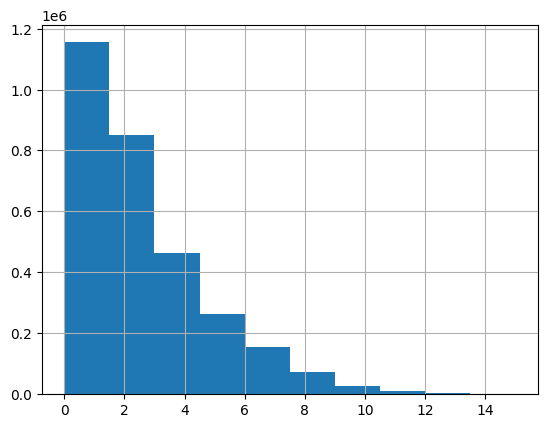

In [30]:
listings_df[listings_df['distance_km'] < 15]['distance_km'].hist()

correlation = listings_df['shopDeliveryFee'].corr(listings_df['distance_km'])
print("Correlation:", correlation)

In [31]:
import pandas as pd
import numpy as np

# Assume listings_df is your DataFrame.

# Convert the relevant columns to numeric, coercing non-numeric values to NaN.
listings_df['promisedDeliveryTimeRangeUpper'] = pd.to_numeric(
    listings_df['promisedDeliveryTimeRangeUpper'], errors='coerce'
)
listings_df['promisedDeliveryTimeRangeLower'] = pd.to_numeric(
    listings_df['promisedDeliveryTimeRangeLower'], errors='coerce'
)
listings_df['shopDeliveryFee'] = pd.to_numeric(
    listings_df['shopDeliveryFee'], errors='coerce'
)

# Optional: Check if conversion worked as expected.
print(listings_df[['promisedDeliveryTimeRangeUpper', 'promisedDeliveryTimeRangeLower', 'shopDeliveryFee']].dtypes)

# Compute the average delivery time.
# (Here I'm taking the midpoint; if you want the sum, remove the division by 2.)
listings_df['average_delivery_time'] = round((
    listings_df['promisedDeliveryTimeRangeUpper'] + listings_df['promisedDeliveryTimeRangeLower']
) / 2,)

epsilon = 1e-6  # small constant to avoid log(0)
listings_df['log_delivery_fee'] = np.log(listings_df['shopDeliveryFee'] + epsilon)
listings_df['log_promised_time'] = np.log(listings_df['average_delivery_time'] + epsilon)

# Add a new column 'click': 1 if session_key_details is not null, else 0
# Ensure None values are treated as NaN
listings_df['session_key_details'] = listings_df['session_key_details'].replace({'None': pd.NA})

# Create the 'click' column: 1 if not NaN, 0 otherwise
listings_df['click'] = listings_df['session_key_details'].notna().astype(int)
# Check the resulting DataFrame
print(listings_df[['promisedDeliveryTimeRangeUpper', 
                   'promisedDeliveryTimeRangeLower', 
                   'average_delivery_time', 
                   'log_delivery_fee', 
                   'log_promised_time', 
                   'click']].head())


# Aggregate the data at the session level
session_df = listings_df.groupby(['session_key','locationCity']).agg(
    avg_delivery_fee = ('shopDeliveryFee', 'mean'),
    avg_delivery_time = ('average_delivery_time', 'mean'),
    click_rate = ('click', 'mean'),    # proportion of shops clicked per session
    num_exposures = ('session_key', 'count')  # number of shops viewed in the session
).reset_index()

# For log-transformation, add a small constant to avoid log(0)
epsilon = 1e-6
session_df['log_avg_delivery_fee'] = np.log(session_df['avg_delivery_fee'] + epsilon)
session_df['log_avg_delivery_time'] = np.log(session_df['avg_delivery_time'] + epsilon)

print(session_df.head())

promisedDeliveryTimeRangeUpper    int64
promisedDeliveryTimeRangeLower    int64
shopDeliveryFee                   int64
dtype: object
   promisedDeliveryTimeRangeUpper  promisedDeliveryTimeRangeLower  \
0                              35                              20   
1                              60                              40   
2                              60                              40   
3                              45                              30   
4                              35                              20   

   average_delivery_time  log_delivery_fee  log_promised_time  click  
0                   28.0          1.945910           3.332205      0  
1                   50.0          1.791760           3.912023      0  
2                   50.0          1.791760           3.912023      0  
3                   38.0          1.945910           3.637586      0  
4                   28.0          1.609438           3.332205      0  
                session_k

In [32]:
listings_df[listings_df['session_key_details'].notna()]

,dh_platform,global_entity_id,platform,session_key,shopId,eventTimestamp,locationLat,locationLon,promisedDeliveryTimeRangeUpper,promisedDeliveryTimeRangeLower,...,longitude,session_key_details,shopId_details,timestamp_details,rn_details,distance_km,average_delivery_time,log_delivery_fee,log_promised_time,click
7,pandora,PO_FI,Android,K3exguJX+JYkJ9plRiHR0g==,ba7n,2025-02-11 15:40:00.076000+00:00,60.361755,23.125612,35,20,...,23.128270,K3exguJX+JYkJ9plRiHR0g==,0,2025-02-11 15:40:00.101000+00:00,1,2.833283,28.0,1.609438,3.332205,1
10,pandora,PO_FI,iOS,PGSJXPWgX+fXkS7CUKsF7A==,w75r,2025-02-05 14:08:03.535000+00:00,60.341332,23.302056,65,45,...,23.142279,PGSJXPWgX+fXkS7CUKsF7A==,0,2025-02-05 14:08:03.916000+00:00,1,10.142410,55.0,2.197225,4.007333,1
30,pandora,PO_FI,iOS,+mgMsbsxULxGIPbOvzqEsg==,f321,2025-02-15 17:37:31.720000+00:00,61.465266,24.057444,70,50,...,23.883312,+mgMsbsxULxGIPbOvzqEsg==,0,2025-02-15 17:37:32.579000+00:00,1,9.844293,60.0,1.791760,4.094345,1
33,pandora,PO_FI,Android,B9iASp+9cHlpI/ebcnEhTQ==,ba7n,2025-02-15 16:37:27.281000+00:00,60.388583,23.141694,40,25,...,23.128270,B9iASp+9cHlpI/ebcnEhTQ==,0,2025-02-15 16:37:45.580000+00:00,1,0.753340,32.0,0.693148,3.465736,1
39,pandora,PO_FI,Android,YXk4f2Yn+3YhDwqkBHPK9w==,s2er,2025-02-08 10:56:29.399000+00:00,60.403724,23.107106,30,15,...,23.102576,YXk4f2Yn+3YhDwqkBHPK9w==,0,2025-02-08 10:56:29.237000+00:00,1,0.860678,22.0,0.693148,3.091042,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3015896,pandora,PO_FI,Android,EoCCEKwz6cugTVUdcRdW3g==,zy39,2025-02-12 08:26:28.484000+00:00,60.267790,25.091300,30,15,...,25.105615,EoCCEKwz6cugTVUdcRdW3g==,0,2025-02-12 08:26:28.560000+00:00,1,1.395364,22.0,1.098613,3.091042,1
3015899,pandora,PO_FI,Android,JuvbJ/b9aFGaUjf2K77ZhQ==,zy39,2025-02-14 15:01:20.071000+00:00,60.282933,25.118100,25,10,...,25.105615,JuvbJ/b9aFGaUjf2K77ZhQ==,0,2025-02-14 15:01:20.115000+00:00,1,0.870564,18.0,0.693148,2.890372,1
3015912,pandora,PO_FI,Android,1VqtHbOcUUFI3hk4wTv37g==,zy39,2025-02-08 12:25:14.591000+00:00,60.284082,25.120945,25,10,...,25.105615,1VqtHbOcUUFI3hk4wTv37g==,0,2025-02-08 12:25:14.657000+00:00,1,1.072835,18.0,1.098613,2.890372,1
3015917,pandora,PO_FI,iOS,F7nm6bGMHQxLh+BLUqg0xg==,h0vs,2025-02-08 15:10:29.966000+00:00,60.317987,24.831766,30,15,...,24.856786,F7nm6bGMHQxLh+BLUqg0xg==,0,2025-02-08 15:10:30.372000+00:00,1,2.283290,22.0,1.609438,3.091042,1


In [33]:
# Create a copy of the listings dataframe to ensure the original remains unchanged
listings_cleaned = listings_df.copy()

# Select only relevant columns
X = listings_cleaned[['shopDeliveryFee', 'average_delivery_time', 'distance_km']]

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove rows with NaN values
X.dropna(inplace=True)

# Add intercept column again
X = sm.add_constant(X)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print VIF results
print(vif_data)


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_87750/2001586015.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_87750/2001586015.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


NameError: name 'variance_inflation_factor' is not defined

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['shopDeliveryFee', 'average_delivery_time', 'distance_km']])

# Apply PCA to get independent components
pca = PCA(n_components=2)  # Reduce to 2 independent factors
X_pca = pca.fit_transform(X_scaled)

# Convert to DataFrame
pca_df = pd.DataFrame(X_pca, columns=['Component1', 'Component2'])

# Add conversion column
pca_df['conversion'] = listings_df['click']

# Run regression with PCA components
X_pca_sm = sm.add_constant(pca_df[['Component1', 'Component2']])
model_pca = sm.OLS(pca_df['conversion'], X_pca_sm).fit()

print(model_pca.summary())


                            OLS Regression Results                            
Dep. Variable:             conversion   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1044
Date:                Sat, 15 Mar 2025   Prob (F-statistic):              0.901
Time:                        00:41:43   Log-Likelihood:            -1.8562e+06
No. Observations:             5618237   AIC:                         3.712e+06
Df Residuals:                 5618234   BIC:                         3.712e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1304      0.000    917.713      0.0

<Axes: >

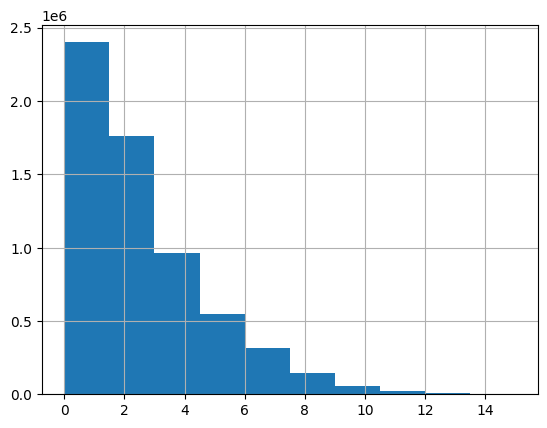

In [ ]:
listings_df[listings_df['distance_km'] < 15]['distance_km'].hist()

<Axes: >

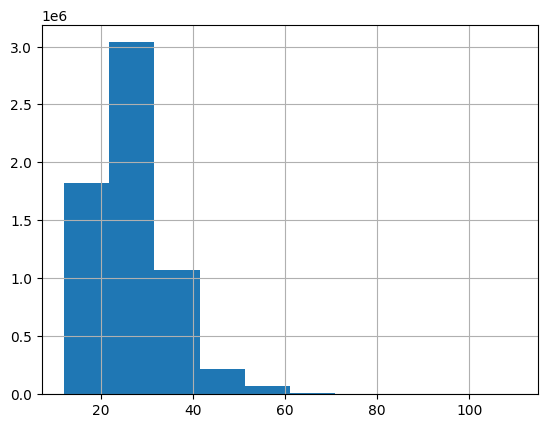

In [ ]:
listings_df[listings_df['average_delivery_time'] < 120]['average_delivery_time'].hist()

<Axes: >

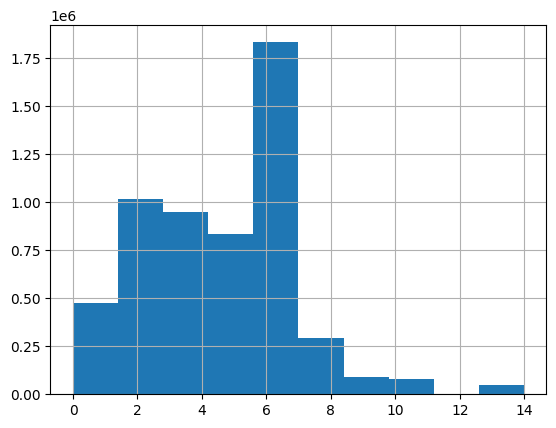

In [ ]:
listings_df[listings_df['shopDeliveryFee'] < 15]['shopDeliveryFee'].hist()

In [ ]:
listings_df.loc[listings_df['shopDeliveryFee'] < 15, 'shopDeliveryFee'] = np.round(
    listings_df['shopDeliveryFee'] * 2
) / 2

listings_df

,dh_platform,global_entity_id,platform,session_key,shopId,eventTimestamp,locationLat,locationLon,promisedDeliveryTimeRangeUpper,promisedDeliveryTimeRangeLower,...,longitude,session_key_details,shopId_details,timestamp_details,rn_details,distance_km,average_delivery_time,log_delivery_fee,log_promised_time,click
0,pandora,PO_FI,iOS,WqjAmtTXvPxhuZGFPeLuKA==,aqar,2025-02-22 09:12:58.086000+00:00,61.465756,23.722124,25,10,...,23.715673,None,None,NaT,<NA>,0.494842,18.0,1.095274,2.890372,0
1,pandora,PO_FI,Android,e/H/9Vx/SWPUqx7ndCGC1Q==,aqar,2025-02-04 09:14:16.953000+00:00,61.456223,23.725504,30,15,...,23.715673,None,None,NaT,<NA>,1.510154,22.0,1.607436,3.091042,0
2,pandora,PO_FI,Android,hqOW3DhcyMpjHknDzt7gBw==,aqar,2025-02-04 11:17:39.450000+00:00,61.473195,23.695462,30,15,...,23.715673,None,None,NaT,<NA>,1.171830,22.0,1.383791,3.091042,0
3,pandora,PO_FI,Android,3j1iFMILLwW8ZEcpueoGtg==,s2kx,2025-02-08 18:10:28.790000+00:00,61.701653,27.302832,35,20,...,27.272811,None,None,NaT,<NA>,2.150423,28.0,1.702928,3.332205,0
4,pandora,PO_FI,iOS,T0+7MWDUFhSZaUu/2iMiEg==,aqar,2025-02-14 13:48:20.920000+00:00,61.470652,23.719350,30,15,...,23.715673,None,None,NaT,<NA>,0.270623,22.0,0.688135,3.091042,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6240298,pandora,PO_FI,iOS,XGBPGB6tXA0zMmZtDODRMQ==,h7dj,2025-02-18 18:54:33.463000+00:00,60.312656,25.038697,25,10,...,25.040296,None,None,NaT,<NA>,2.250136,18.0,1.756132,2.890372,0
6240299,pandora,PO_FI,Android,l3rW3zPoWgBKFYcR/PMfMw==,h7dj,2025-02-22 17:25:49.923000+00:00,60.285138,25.044032,35,10,...,25.040296,None,None,NaT,<NA>,0.837133,22.0,1.026042,3.091042,0
6240300,pandora,PO_FI,iOS,uH/znMCrS2NGfKZAEM+WIA==,nfbd,2025-02-08 15:32:02.369000+00:00,60.319050,25.095640,30,15,...,25.074174,None,None,NaT,<NA>,1.311510,22.0,-13.815511,3.091042,0
6240301,pandora,PO_FI,iOS,6eeEoYMwMWnJkTDklauohA==,k9gh,2025-02-13 11:10:03.635000+00:00,60.290535,25.021258,30,15,...,25.031150,None,None,NaT,<NA>,0.645780,22.0,0.912283,3.091042,0


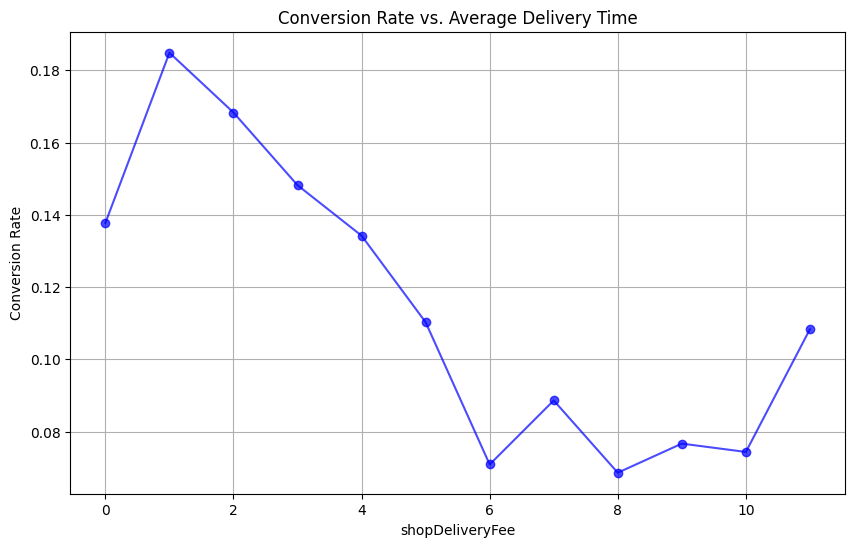

In [ ]:
tt = listings_df.groupby('shopDeliveryFee').agg(
    converted = ('click', 'sum'),
    total_shops=('shopId','count')
).reset_index()

tt['coversion'] = tt['converted'] / tt['total_shops']

tt = tt[tt['shopDeliveryFee'] < 12]

# Plot conversion rate against average delivery time
plt.figure(figsize=(10, 6))
plt.plot(tt['shopDeliveryFee'], tt['coversion'], marker='o', linestyle='-', color='b', alpha=0.7)
plt.xlabel("shopDeliveryFee")
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate vs. Average Delivery Time")
plt.grid(True)
plt.show()

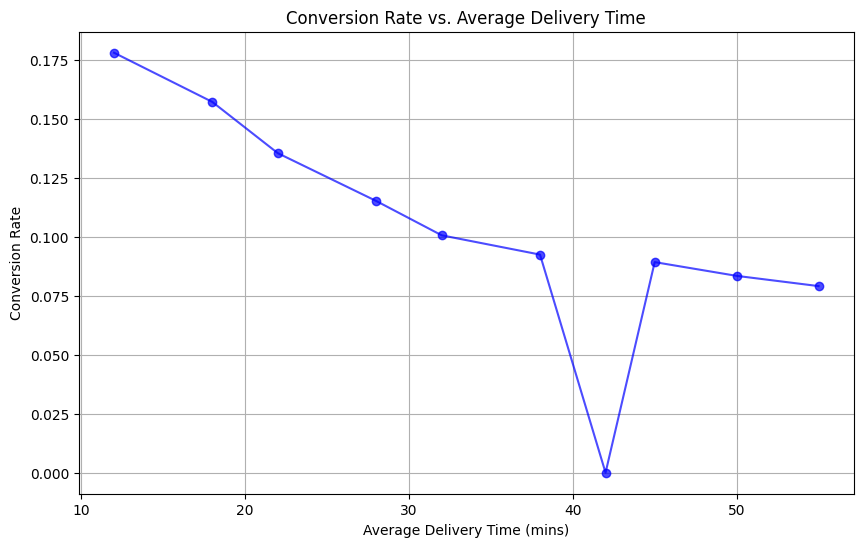

In [ ]:
tt = listings_df.groupby('average_delivery_time').agg(
    converted = ('click', 'sum'),
    total_shops=('shopId','count')
).reset_index()

tt['coversion'] = tt['converted'] / tt['total_shops']

tt  = tt[(tt['average_delivery_time'] < 60) & (tt['average_delivery_time'] > 0)]

# Plot conversion rate against average delivery time
plt.figure(figsize=(10, 6))
plt.plot(tt['average_delivery_time'], tt['coversion'], marker='o', linestyle='-', color='b', alpha=0.7)
plt.xlabel("Average Delivery Time (mins)")
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate vs. Average Delivery Time")
plt.grid(True)
plt.show()


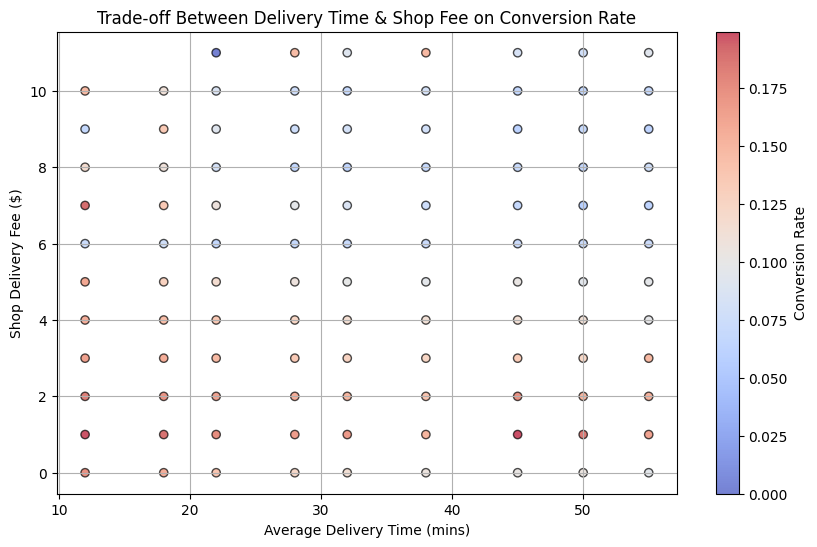

In [ ]:
# Filter out extreme values before grouping
filtered_df = listings_df[(listings_df['average_delivery_time'] < 60) & 
                          (listings_df['average_delivery_time'] > 0) &
                          (listings_df['shopDeliveryFee'] < 12)]

# Aggregate conversion rate by (delivery_time, shop_fee)
tt = filtered_df.groupby(['average_delivery_time', 'shopDeliveryFee']).agg(
    converted=('click', 'sum'),
    total_shops=('shopId', 'count')
).reset_index()

# Compute conversion rate
tt['conversion'] = tt['converted'] / tt['total_shops']

# Scatter plot to show trade-off between delivery time and shop fee
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    tt['average_delivery_time'], tt['shopDeliveryFee'], 
    c=tt['conversion'], cmap='coolwarm', alpha=0.7, edgecolors='k'
)
plt.colorbar(scatter, label='Conversion Rate')
plt.xlabel("Average Delivery Time (mins)")
plt.ylabel("Shop Delivery Fee ($)")
plt.title("Trade-off Between Delivery Time & Shop Fee on Conversion Rate")
plt.grid(True)
plt.show()


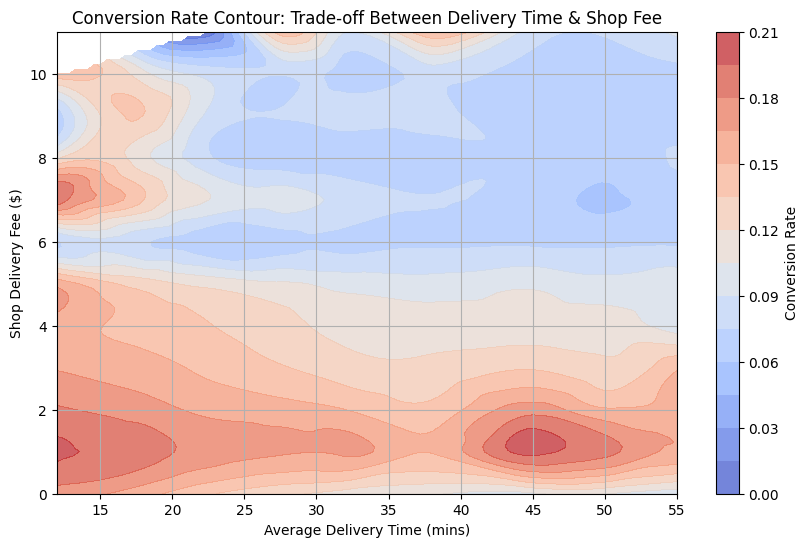

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

# Create a grid for smoother visualization
x = tt['average_delivery_time']
y = tt['shopDeliveryFee']
z = tt['conversion']

# Create a grid for contour plot
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate conversion rate over the grid
zi = scipy.interpolate.griddata((x, y), z, (xi, yi), method='cubic')

# Plot contour chart
plt.figure(figsize=(10, 6))
contour = plt.contourf(xi, yi, zi, levels=15, cmap='coolwarm', alpha=0.75)
plt.colorbar(label="Conversion Rate")
plt.xlabel("Average Delivery Time (mins)")
plt.ylabel("Shop Delivery Fee ($)")
plt.title("Conversion Rate Contour: Trade-off Between Delivery Time & Shop Fee")
plt.grid(True)
plt.show()


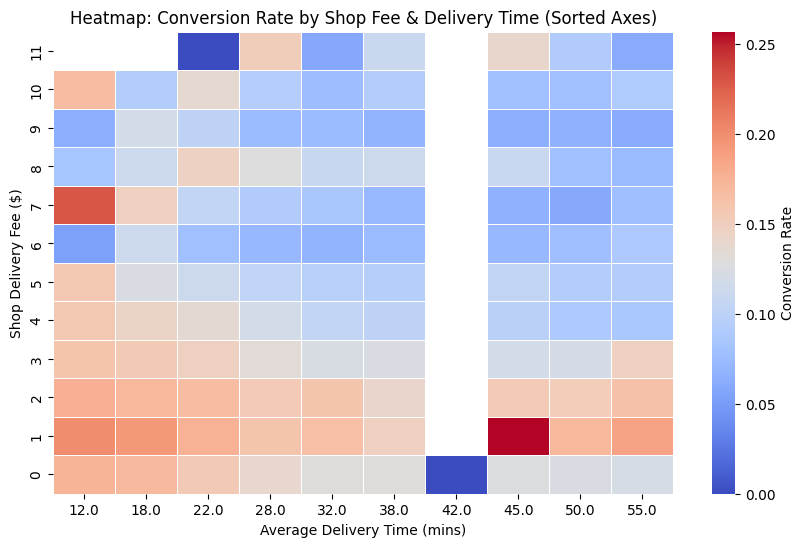

In [ ]:
# Ensure index (Y-axis: Delivery Time) and columns (X-axis: Shop Fee) are sorted in the correct order
heatmap_data = heatmap_data.sort_index(ascending=False)  # Sort Delivery Time (Y-axis) in descending order
heatmap_data = heatmap_data.sort_index(axis=1, ascending=True)  # Sort Shop Fee (X-axis) in ascending order

# Plot heatmap again with corrected axis ordering
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, linewidths=0.5, cbar_kws={'label': 'Conversion Rate'})
plt.xlabel("Average Delivery Time (mins)")  # X-axis represents Shop Fee
plt.ylabel("Shop Delivery Fee ($)")  # Y-axis represents Delivery Time
plt.title("Heatmap: Conversion Rate by Shop Fee & Delivery Time (Sorted Axes)")
plt.show()


In [ ]:
listings_df.columns

Index(['dh_platform', 'global_entity_id', 'platform', 'session_key', 'shopId',
       'eventTimestamp', 'locationLat', 'locationLon',
       'promisedDeliveryTimeRangeUpper', 'promisedDeliveryTimeRangeLower',
       'locationCountry', 'locationCity', 'shopDeliveryFee', 'serviceFee',
       'shopMinimumOrderValue', 'shopSponsoring', 'shopPosition',
       'perseusClientId', 'pageType', 'userId', 'eventAction',
       'shopRatingQuality', 'rn', 'vertical_type', 'chain_id', 'chain_name',
       'vendor_name', 'latitude', 'longitude', 'session_key_details',
       'shopId_details', 'timestamp_details', 'rn_details', 'distance_km',
       'average_delivery_time', 'log_delivery_fee', 'log_promised_time',
       'click'],
      dtype='object')

In [ ]:
df_session

,session_key,shopId,conversions,shop_fee,delivery_time,distance_km,log_shop_fee,log_delivery_time,log_distance_km,log_fee_x_time,log_shop_fee_sq
0,+++b0H7fIGqLENadjkvesQ==,lv3w,0,5.49,18.0,2.008263,1.870263,2.944439,1.101363,5.506874,3.497882
1,++0B4qQM4ms6wCHwK9HqpQ==,v2bu,0,5.49,22.0,2.531617,1.870263,3.135494,1.261756,5.864197,3.497882
2,++17LRnS46b9xDXOdMQn/g==,aod7,0,1.99,12.0,0.497068,1.095273,2.564949,0.403509,2.809321,1.199624
3,++17LRnS46b9xDXOdMQn/g==,qkwv,0,4.99,22.0,1.796913,1.790091,3.135494,1.028516,5.612821,3.204427
4,++17LRnS46b9xDXOdMQn/g==,s2rj,0,2.99,22.0,0.720644,1.383791,3.135494,0.542698,4.338869,1.914878
...,...,...,...,...,...,...,...,...,...,...,...
2413585,zzyouJB8HSNXzJmasr7VQw==,ws1i,0,4.49,22.0,1.587483,1.702928,3.135494,0.950686,5.339522,2.899965
2413586,zzzOsph/9MDXTOAJ1E9TbQ==,s3br,0,5.79,12.0,2.710330,1.915451,2.564949,1.311121,4.913035,3.668952
2413587,zzze2qeZur9ZLdsbcL1ZWw==,wmx9,0,3.79,12.0,1.239496,1.566530,2.564949,0.806251,4.018071,2.454018
2413588,zzzg1GUgydPRRN6lbyh4/w==,v5cb,0,5.79,22.0,3.800552,1.915451,3.135494,1.568731,6.005885,3.668952


In [ ]:
import numpy as np
import statsmodels.formula.api as smf

# Aggregate number of conversions per session
df_session = filtered_df.groupby(["session_key", "shopId"]).agg(
    conversions=("click", "sum"),
    shop_fee=("shopDeliveryFee", "max"),
    delivery_time=("average_delivery_time", "first"),
    distance_km=("distance_km", "first")  # Include distance
).reset_index()

# Log transform shop fee, delivery time, and distance
df_session["log_shop_fee"] = np.log1p(df_session["shop_fee"])
df_session["log_delivery_time"] = np.log1p(df_session["delivery_time"])
df_session["log_distance_km"] = np.log1p(df_session["distance_km"])  # New transformation

# Poisson Regression with Fixed Effects
model = smf.poisson("conversions ~ log_shop_fee + log_delivery_time + log_distance_km", data=df_session).fit()

print(model.summary())


NameError: name 'filtered_df' is not defined

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Aggregate number of conversions per session
df_session = filtered_df.groupby(["session_key", "shopId"]).agg(
    conversions=("click", "sum"),
    shop_fee=("shopDeliveryFee", "max"),
    delivery_time=("average_delivery_time", "first"),
).reset_index()

# Log transform shop fee and delivery time
df_session["log_shop_fee"] = np.log1p(df_session["shop_fee"])
df_session["log_delivery_time"] = np.log1p(df_session["delivery_time"])

# Poisson Regression with Fixed Effects
model = smf.poisson("conversions ~ log_shop_fee + log_delivery_time", data=df_session).fit()

print(model.summary())

NameError: name 'filtered_df' is not defined

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np


# Fractional Logit (Using GLM with Binomial family)
model = smf.glm(
    "conversions ~ log_shop_fee + log_delivery_time", 
    data=df_session, 
    family=sm.families.Binomial()
).fit()

print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            conversions   No. Observations:              6161191
Model:                            GLM   Df Residuals:                  6161188
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3741e+06
Date:                Sat, 15 Mar 2025   Deviance:                   4.7481e+06
Time:                        02:18:51   Pearson chi2:                 6.16e+06
No. Iterations:                     5   Pseudo R-squ. (CS):           0.006570
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2300      0.01

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

df_session["log_fee_x_time"] = df_session["log_shop_fee"] * df_session["log_delivery_time"]
df_session["log_shop_fee_sq"] = df_session["log_shop_fee"] ** 2
df_session["log_fee_x_distance"] = df_session["log_shop_fee"] * df_session["log_distance_km"]

model_nb = smf.glm(
    "conversions ~ log_shop_fee + log_shop_fee_sq + log_delivery_time + log_distance_km",  
    data=df_session,
    family=sm.families.NegativeBinomial()
).fit()

# model_nb = smf.glm(
#     "conversions ~ log_shop_fee + log_shop_fee_sq + log_delivery_time + log_fee_x_time + log_distance_km + log_fee_x_distance",  
#     data=df_session,
#     family=sm.families.NegativeBinomial()
# ).fit()

print(model_nb.summary())

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:            conversions   No. Observations:              6161191
Model:                            GLM   Df Residuals:                  6161186
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4743e+06
Date:                Sat, 15 Mar 2025   Deviance:                   2.7077e+06
Time:                        12:15:05   Pearson chi2:                 4.73e+06
No. Iterations:                     6   Pseudo R-squ. (CS):           0.008541
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.9403      0.01

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Model 1: Without interactions
model_without_interactions = smf.glm(
    "conversions ~ log_shop_fee + log_shop_fee_sq + log_delivery_time + log_distance_km",
    data=df_session,
    family=sm.families.NegativeBinomial()
).fit()

# Model 2: With interactions
model_with_interactions = smf.glm(
    "conversions ~ log_shop_fee + log_shop_fee_sq + log_delivery_time + log_distance_km + log_fee_x_time + log_fee_x_distance",
    data=df_session,
    family=sm.families.NegativeBinomial()
).fit()

import scipy.stats as stats

# Compute AIC and BIC for both models
aic_without = model_without_interactions.aic
bic_without = model_without_interactions.bic
aic_with = model_with_interactions.aic
bic_with = model_with_interactions.bic

# Likelihood Ratio Test (LRT)
lr_stat = 2 * (model_with_interactions.llf - model_without_interactions.llf)
df_diff = model_with_interactions.df_model - model_without_interactions.df_model
p_value = stats.chi2.sf(lr_stat, df_diff)  # Corrected way to compute p-value

# Display results
results = {
    "AIC Without Interactions": aic_without,
    "AIC With Interactions": aic_with,
    "BIC Without Interactions": bic_without,
    "BIC With Interactions": bic_with,
    "Likelihood Ratio Test Statistic": lr_stat,
    "p-value (LRT)": p_value
}

results


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this mes

{'AIC Without Interactions': 4948560.76719061,
 'AIC With Interactions': 4947695.044267173,
 'BIC Without Interactions': -93614938.6527914,
 'BIC With Interactions': -93615777.1081535,
 'Likelihood Ratio Test Statistic': 869.7229234371334,
 'p-value (LRT)': 1.386969092402039e-189}

In [ ]:
print(model_with_interactions.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            conversions   No. Observations:              6161191
Model:                            GLM   Df Residuals:                  6161184
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4738e+06
Date:                Sat, 15 Mar 2025   Deviance:                   2.7068e+06
Time:                        12:23:19   Pearson chi2:                 4.73e+06
No. Iterations:                     6   Pseudo R-squ. (CS):           0.008681
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.2403      0

In [ ]:
# Ensure squared terms exist in the dataset
df_session["log_shop_fee_sq"] = df_session["log_shop_fee"] ** 2
df_session["log_delivery_time_sq"] = df_session["log_delivery_time"] ** 2

# Create interaction terms for non-linear relationships
df_session["log_fee_x_distance"] = df_session["log_shop_fee"] * df_session["log_distance_km"]
df_session["log_time_x_distance"] = df_session["log_delivery_time"] * df_session["log_distance_km"]

# Fit the non-linear model with quadratic terms and interactions
nonlinear_model = smf.glm(
    "conversions ~ log_shop_fee + log_shop_fee_sq + log_delivery_time + log_delivery_time_sq + log_distance_km + log_fee_x_distance + log_time_x_distance",
    data=df_session,
    family=sm.families.NegativeBinomial()
).fit()

# Display model summary
nonlinear_model.summary()


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            conversions   No. Observations:              6161191
Model:                            GLM   Df Residuals:                  6161183
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4739e+06
Date:                Sat, 15 Mar 2025   Deviance:                   2.7069e+06
Time:                        12:44:33   Pearson chi2:                 4.73e+06
No. Iterations:                     6   Pseudo R-squ. (CS):           0.008665
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.6544      0.097     -6.764      0.000      -0.844      -0.465
log_shop_fee            -0.0165      0.008     -2.102      0.036      -0.032      -0.001
log_shop_fee_sq          0.0837      0.006     13.938      0.000       0.072       0.095
log_delivery_time       -0.4654      0.067     -6.981      0.000      -0.596      -0.335
log_delivery_time_sq     0.0483      0.012      4.183      0.000       0.026       0.071
log_distance_km         -0.2048      0.031     -6.560      0.000      -0.266      -0.144
log_fee_x_distance      -0.1130      0.005    -23.684      0.000      -0.122      -0.104
log_time_x_distance     -0.0456      0.010     -4.573      0.000      -0.065      -0.026
========================================================================================
"""

In [ ]:
!pip3 install pymc --no-deps

ModuleNotFoundError: No module named 'pty'

In [ ]:
import pymc as pm
import numpy as np
import pandas as pd

# Select key variables
data = df_session[["log_shop_fee", "log_delivery_time", "log_distance_km", "conversions", "shopId"]]

# Standardize continuous variables (Bayesian models work better with normalized data)
data["log_shop_fee_scaled"] = (data["log_shop_fee"] - data["log_shop_fee"].mean()) / data["log_shop_fee"].std()
data["log_delivery_time_scaled"] = (data["log_delivery_time"] - data["log_delivery_time"].mean()) / data["log_delivery_time"].std()
data["log_distance_km_scaled"] = (data["log_distance_km"] - data["log_distance_km"].mean()) / data["log_distance_km"].std()

# Unique shops
shop_ids = data["shopId"].unique()
shop_idx = pd.factorize(data["shopId"])[0]  # Convert shop IDs to integer indices

# Bayesian Model
with pm.Model() as hierarchical_model:
    # Global Intercept
    beta_0 = pm.Normal("beta_0", mu=0, sigma=1)

    # Global Effects (Fixed Effects)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=1)  # Effect of fee
    beta_2 = pm.Normal("beta_2", mu=0, sigma=1)  # Effect of delivery time
    beta_3 = pm.Normal("beta_3", mu=0, sigma=1)  # Effect of distance

    # Shop-Specific Random Effects
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=1)
    alpha_shop = pm.Normal("alpha_shop", mu=0, sigma=sigma_alpha, shape=len(shop_ids))

    # Expected conversions (log-linear model)
    lambda_ = pm.math.exp(
        beta_0
        + beta_1 * data["log_shop_fee_scaled"]
        + beta_2 * data["log_delivery_time_scaled"]
        + beta_3 * data["log_distance_km_scaled"]
        + alpha_shop[shop_idx]  # Shop-specific effect
    )

    # Negative Binomial Likelihood (to model count data)
    conversions = pm.NegativeBinomial("conversions", mu=lambda_, alpha=2, observed=data["conversions"])

    # Sample from posterior distribution
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

# Summary of Bayesian estimates
print(pm.summary(trace))


ModuleNotFoundError: No module named 'pymc'

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix
import pandas as pd

# Generate spline basis functions for log_shop_fee and log_delivery_time
df_spline_fee = dmatrix("bs(log_shop_fee, df=4, degree=3) - 1", data=df_session, return_type='dataframe')
df_spline_time = dmatrix("bs(log_delivery_time, df=4, degree=3) - 1", data=df_session, return_type='dataframe')

# Rename columns to prevent conflicts
df_spline_fee.columns = [f"log_shop_fee_spline_{i}" for i in range(df_spline_fee.shape[1])]
df_spline_time.columns = [f"log_delivery_time_spline_{i}" for i in range(df_spline_time.shape[1])]

# Merge spline features into the original dataset
df_session = pd.concat([df_session, df_spline_fee, df_spline_time], axis=1)

# Construct the model formula using all spline columns
gam_formula = "conversions ~ " + " + ".join(df_spline_fee.columns) + " + " + " + ".join(df_spline_time.columns) + " + log_distance_km"

# Fit the model using a Negative Binomial family
gam_model = smf.glm(gam_formula, data=df_session, family=sm.families.NegativeBinomial()).fit()

# Display model summary
print(gam_model.summary())


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:            conversions   No. Observations:              6161191
Model:                            GLM   Df Residuals:                  6161181
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4742e+06
Date:                Sat, 15 Mar 2025   Deviance:                   2.7075e+06
Time:                        13:18:08   Pearson chi2:                 4.70e+06
No. Iterations:                   100   Pseudo R-squ. (CS):           0.008571
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

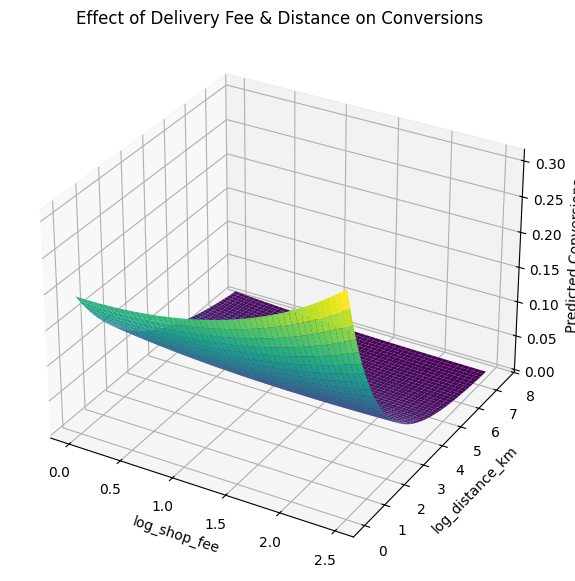

ValueError: Cannot set a DataFrame with multiple columns to the single column log_shop_fee_spline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

### 1️⃣ Visualizing Combined Effects in a 3D Surface Plot ###

# Define grid ranges
log_shop_fee_range = np.linspace(df_session["log_shop_fee"].min(), df_session["log_shop_fee"].max(), 50)
log_delivery_time_range = np.linspace(df_session["log_delivery_time"].min(), df_session["log_delivery_time"].max(), 50)
log_distance_km_range = np.linspace(df_session["log_distance_km"].min(), df_session["log_distance_km"].max(), 50)

# Create mesh grid for fee vs. distance (keeping delivery time fixed)
log_shop_fee_grid, log_distance_km_grid = np.meshgrid(log_shop_fee_range, log_distance_km_range)
log_delivery_time_fixed = np.mean(df_session["log_delivery_time"])

# Create dataframe for predictions
df_pdp_fee_distance = pd.DataFrame({
    "log_shop_fee": log_shop_fee_grid.ravel(),
    "log_shop_fee_sq": log_shop_fee_grid.ravel() ** 2,
    "log_delivery_time": log_delivery_time_fixed,
    "log_delivery_time_sq": log_delivery_time_fixed ** 2,
    "log_distance_km": log_distance_km_grid.ravel(),
    "log_fee_x_distance": (log_shop_fee_grid * log_distance_km_grid).ravel(),
    "log_time_x_distance": (log_delivery_time_fixed * log_distance_km_grid).ravel(),
})

# Predict conversions
predicted_conversions_fee_distance = nonlinear_model.predict(df_pdp_fee_distance).values.reshape(log_shop_fee_grid.shape)

# 3D Plot: Fee vs. Distance
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(log_shop_fee_grid, log_distance_km_grid, predicted_conversions_fee_distance, cmap="viridis")

ax.set_xlabel("log_shop_fee")
ax.set_ylabel("log_distance_km")
ax.set_zlabel("Predicted Conversions")
ax.set_title("Effect of Delivery Fee & Distance on Conversions")

plt.show()

### 2️⃣ Fit a Non-Linear Model Using Splines ###

# Generate spline basis functions for fee and delivery time
df_session["log_shop_fee_spline"] = dmatrix("bs(log_shop_fee, df=4, degree=3)", data=df_session, return_type='dataframe')
df_session["log_delivery_time_spline"] = dmatrix("bs(log_delivery_time, df=4, degree=3)", data=df_session, return_type='dataframe')

# Fit the spline-based model
spline_model = smf.glm(
    "conversions ~ log_shop_fee_spline + log_delivery_time_spline + log_distance_km + log_fee_x_distance + log_time_x_distance",
    data=df_session,
    family=sm.families.NegativeBinomial()
).fit()

# Display summary
spline_model.summary()


In [ ]:
from patsy import dmatrix

# Generate spline basis functions for log_shop_fee and log_delivery_time
df_spline_fee = dmatrix("bs(log_shop_fee, df=4, degree=3) - 1", data=df_session, return_type='dataframe')
df_spline_time = dmatrix("bs(log_delivery_time, df=4, degree=3) - 1", data=df_session, return_type='dataframe')

# Rename columns to avoid conflicts
df_spline_fee.columns = [f"log_shop_fee_spline_{i}" for i in range(df_spline_fee.shape[1])]
df_spline_time.columns = [f"log_delivery_time_spline_{i}" for i in range(df_spline_time.shape[1])]

# Merge spline features into the original dataset
df_session = pd.concat([df_session, df_spline_fee, df_spline_time], axis=1)

# Manually construct the formula
spline_model_formula = "conversions ~ " + " + ".join(df_spline_fee.columns) + " + " + " + ".join(df_spline_time.columns) + " + log_distance_km + log_fee_x_distance + log_time_x_distance"

# Fit the model
spline_model = smf.glm(
    spline_model_formula,
    data=df_session,
    family=sm.families.NegativeBinomial()
).fit()

# Display summary
spline_model.summary()


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            conversions   No. Observations:              6161191
Model:                            GLM   Df Residuals:                  6161179
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4738e+06
Date:                Sat, 15 Mar 2025   Deviance:                   2.7068e+06
Time:                        12:49:47   Pearson chi2:                 4.73e+06
No. Iterations:                     6   Pseudo R-squ. (CS):           0.008692
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.5696      0.007   -227.013      0.000      -1.583      -1.556
log_shop_fee_spline_0          0.0536      0.013      4.135      0.000       0.028       0.079
log_shop_fee_spline_1          0.0503      0.013      3.803      0.000       0.024       0.076
log_shop_fee_spline_2          0.4152      0.023     17.705      0.000       0.369       0.461
log_shop_fee_spline_3          0.5779      0.031     18.924      0.000       0.518       0.638
log_delivery_time_spline_0     0.0190      0.009      2.079      0.038       0.001       0.037
log_delivery_time_spline_1    -0.1387      0.013    -10.675      0.000      -0.164      -0.113
log_delivery_time_spline_2    -0.1724      0.017    -10.087      0.000      -0.206      -0.139
log_delivery_time_spline_3    -0.0943      0.022     -4.290      0.000      -0.137      -0.051
log_distance_km               -0.1042      0.033     -3.161      0.002      -0.169      -0.040
log_fee_x_distance            -0.1240      0.005    -23.612      0.000      -0.134      -0.114
log_time_x_distance           -0.0726      0.010     -7.033      0.000      -0.093      -0.052
==============================================================================================
"""

In [ ]:
# Ensure squared terms exist in the dataset
df_session["log_shop_fee_sq"] = df_session["log_shop_fee"] ** 2
df_session["log_delivery_time_sq"] = df_session["log_delivery_time"] ** 2

# Create interaction terms for non-linear relationships
df_session["log_fee_x_distance"] = df_session["log_shop_fee"] * df_session["log_distance_km"]
df_session["log_time_x_distance"] = df_session["log_delivery_time"] * df_session["log_distance_km"]

# Fit the quadratic model again
nonlinear_model = smf.glm(
    "conversions ~ log_shop_fee + log_shop_fee_sq + log_delivery_time + log_delivery_time_sq + log_distance_km + log_fee_x_distance + log_time_x_distance",
    data=df_session,
    family=sm.families.NegativeBinomial()
).fit()


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [ ]:
import scipy.stats as stats

# Compute AIC and BIC for both models
aic_nonlinear = nonlinear_model.aic  # Quadratic model
bic_nonlinear = nonlinear_model.bic

aic_spline = spline_model.aic  # Spline-based model
bic_spline = spline_model.bic

# Likelihood Ratio Test (LRT)
lr_stat = 2 * (spline_model.llf - nonlinear_model.llf)
df_diff = spline_model.df_model - nonlinear_model.df_model
p_value = stats.chi2.sf(lr_stat, df_diff)  # Compute p-value

# Display results
model_comparison = {
    "AIC (Quadratic Model)": aic_nonlinear,
    "AIC (Spline Model)": aic_spline,
    "BIC (Quadratic Model)": bic_nonlinear,
    "BIC (Spline Model)": bic_spline,
    "Likelihood Ratio Test Statistic": lr_stat,
    "p-value (LRT)": p_value
}

model_comparison


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


{'AIC (Quadratic Model)': 4947801.272613223,
 'AIC (Spline Model)': 4947641.001076529,
 'BIC (Quadratic Model)': -93615657.24602678,
 'BIC (Spline Model)': -93615762.98244084,
 'Likelihood Ratio Test Statistic': 168.27153669390827,
 'p-value (LRT)': 2.45703948718773e-35}

In [ ]:
%pip install pymc

ModuleNotFoundError: No module named 'pty'

In [ ]:
%pip install XGBRegressor

ModuleNotFoundError: No module named 'pty'

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Select features and target
X = df_session[["log_shop_fee", "log_delivery_time", "log_distance_km"]]
y = df_session["conversions"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred = xgb_model.predict(X_test)

# Evaluate performance
from sklearn.metrics import mean_squared_error
print("MSE:", mean_squared_error(y_test, y_pred))


ModuleNotFoundError: No module named 'xgboost'

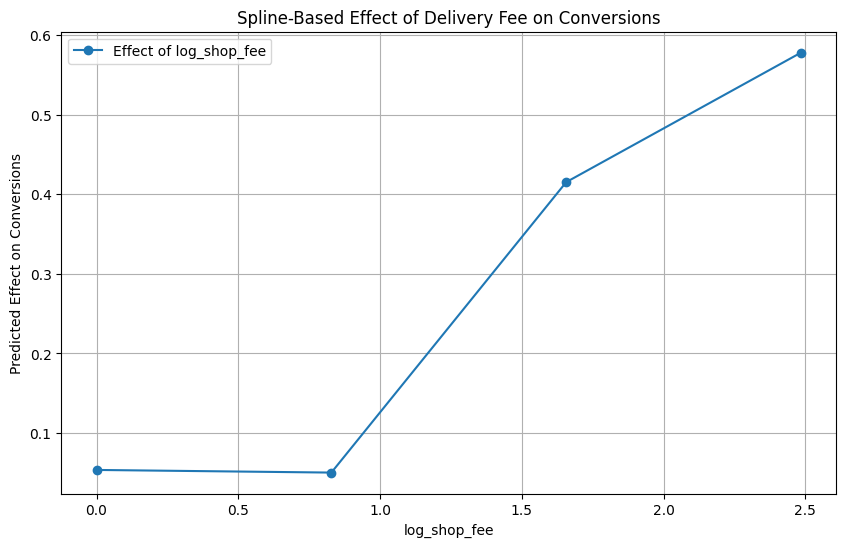

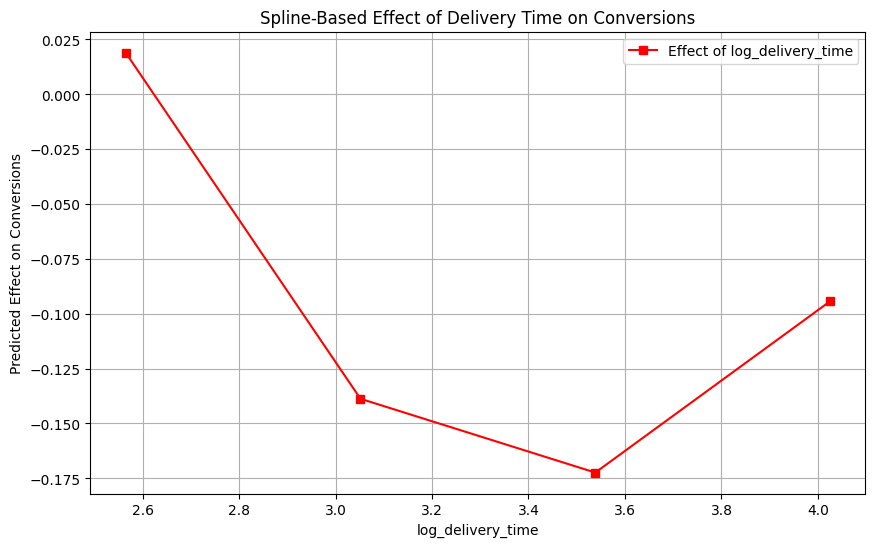

In [ ]:
import matplotlib.pyplot as plt

# Extract predicted spline effects for log_shop_fee
spline_fee_effects = spline_model.params.filter(like="log_shop_fee_spline_")
spline_fee_range = np.linspace(df_session["log_shop_fee"].min(), df_session["log_shop_fee"].max(), len(spline_fee_effects))

# Extract predicted spline effects for log_delivery_time
spline_time_effects = spline_model.params.filter(like="log_delivery_time_spline_")
spline_time_range = np.linspace(df_session["log_delivery_time"].min(), df_session["log_delivery_time"].max(), len(spline_time_effects))

# Plot the effect of log_shop_fee splines
plt.figure(figsize=(10, 6))
plt.plot(spline_fee_range, spline_fee_effects.values, marker="o", label="Effect of log_shop_fee")
plt.xlabel("log_shop_fee")
plt.ylabel("Predicted Effect on Conversions")
plt.title("Spline-Based Effect of Delivery Fee on Conversions")
plt.legend()
plt.grid()

# Plot the effect of log_delivery_time splines
plt.figure(figsize=(10, 6))
plt.plot(spline_time_range, spline_time_effects.values, marker="s", color="red", label="Effect of log_delivery_time")
plt.xlabel("log_delivery_time")
plt.ylabel("Predicted Effect on Conversions")
plt.title("Spline-Based Effect of Delivery Time on Conversions")
plt.legend()
plt.grid()

plt.show()


In [ ]:
!pip install numpy scipy cython
#!pip install pygam

ModuleNotFoundError: No module named 'pty'

In [ ]:
from pygam import LinearGAM, s, f

# Prepare data for GAM model
X = df_session[["log_shop_fee", "log_delivery_time", "log_distance_km"]].values
y = df_session["conversions"].values

# Fit a Generalized Additive Model (GAM) with spline smoothing for non-linear relationships
gam_model = LinearGAM(s(0) + s(1) + s(2) + f(0)).fit(X, y)

# Generate predictions for visualization
XX = gam_model.generate_X_grid(term=0)  # Generate grid for log_shop_fee
predictions_fee = gam_model.partial_dependence(term=0, X=XX)  # Effect of log_shop_fee

XX_time = gam_model.generate_X_grid(term=1)  # Generate grid for log_delivery_time
predictions_time = gam_model.partial_dependence(term=1, X=XX_time)  # Effect of log_delivery_time

XX_distance = gam_model.generate_X_grid(term=2)  # Generate grid for log_distance_km
predictions_distance = gam_model.partial_dependence(term=2, X=XX_distance)  # Effect of log_distance_km

# Plot the GAM smoothed effects

# Effect of Delivery Fee
plt.figure(figsize=(10, 6))
plt.plot(XX[:, 0], predictions_fee, color="blue", label="Effect of log_shop_fee")
plt.xlabel("log_shop_fee")
plt.ylabel("Effect on Conversions")
plt.title("GAM-Based Effect of Delivery Fee on Conversions")
plt.legend()
plt.grid()

# Effect of Delivery Time
plt.figure(figsize=(10, 6))
plt.plot(XX_time[:, 0], predictions_time, color="red", label="Effect of log_delivery_time")
plt.xlabel("log_delivery_time")
plt.ylabel("Effect on Conversions")
plt.title("GAM-Based Effect of Delivery Time on Conversions")
plt.legend()
plt.grid()

# Effect of Distance
plt.figure(figsize=(10, 6))
plt.plot(XX_distance[:, 0], predictions_distance, color="green", label="Effect of log_distance_km")
plt.xlabel("log_distance_km")
plt.ylabel("Effect on Conversions")
plt.title("GAM-Based Effect of Distance on Conversions")
plt.legend()
plt.grid()

plt.show()


ModuleNotFoundError: No module named 'pygam'

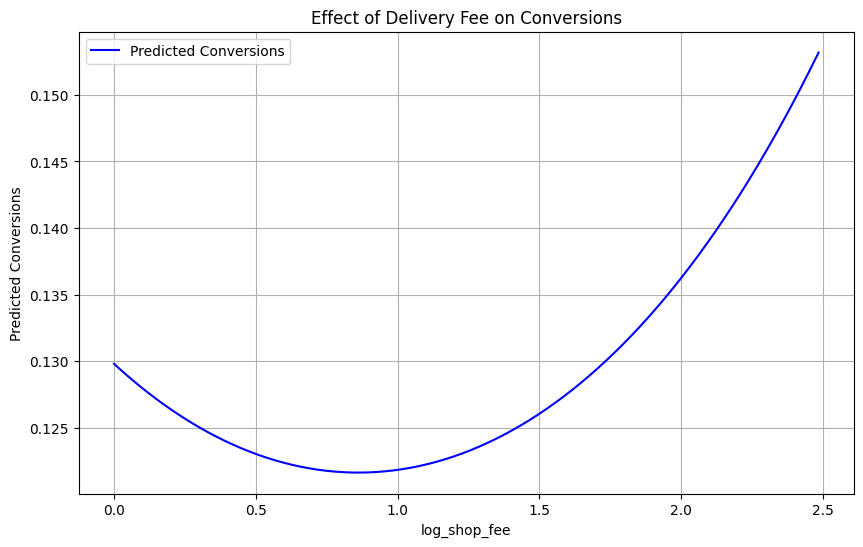

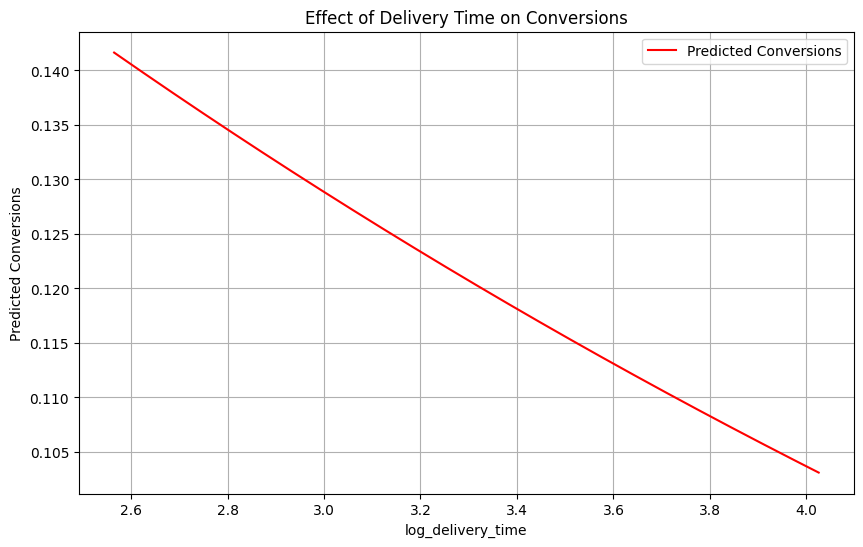

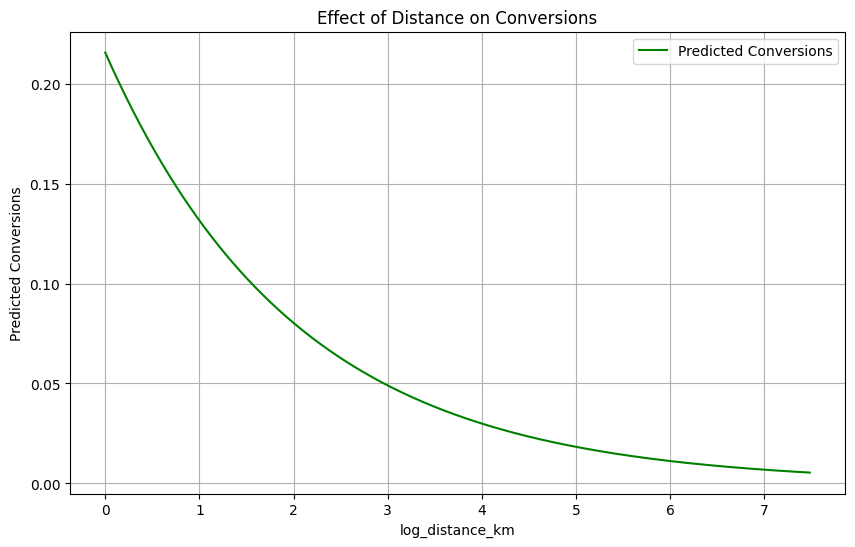

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Ensure squared term exists
df_session["log_shop_fee_sq"] = df_session["log_shop_fee"] ** 2

# Define mean values for other predictors
mean_shop_fee = df_session["log_shop_fee"].mean()
mean_delivery_time = df_session["log_delivery_time"].mean()
mean_distance = df_session["log_distance_km"].mean()

# Generate ranges for variables
log_shop_fee_range = np.linspace(df_session["log_shop_fee"].min(), df_session["log_shop_fee"].max(), 500)
log_delivery_time_range = np.linspace(df_session["log_delivery_time"].min(), df_session["log_delivery_time"].max(), 500)
log_distance_km_range = np.linspace(df_session["log_distance_km"].min(), df_session["log_distance_km"].max(), 500)

# Convert to DataFrames with matching dimensions
df_fee = pd.DataFrame({
    "log_shop_fee": log_shop_fee_range,
    "log_shop_fee_sq": log_shop_fee_range ** 2,
    "log_delivery_time": mean_delivery_time,
    "log_distance_km": mean_distance,
    "log_fee_x_time": log_shop_fee_range * mean_delivery_time,
    "log_fee_x_distance": log_shop_fee_range * mean_distance
})

df_time = pd.DataFrame({
    "log_shop_fee": mean_shop_fee,
    "log_shop_fee_sq": mean_shop_fee ** 2,
    "log_delivery_time": log_delivery_time_range,
    "log_distance_km": mean_distance,
    "log_fee_x_time": mean_shop_fee * log_delivery_time_range,
    "log_fee_x_distance": mean_shop_fee * mean_distance
})

df_distance = pd.DataFrame({
    "log_shop_fee": mean_shop_fee,
    "log_shop_fee_sq": mean_shop_fee ** 2,
    "log_delivery_time": mean_delivery_time,
    "log_distance_km": log_distance_km_range,
    "log_fee_x_time": mean_shop_fee * mean_delivery_time,
    "log_fee_x_distance": mean_shop_fee * log_distance_km_range
})

# Predict conversions for each case
fee_predictions = model_with_interactions.predict(df_fee)
time_predictions = model_with_interactions.predict(df_time)
distance_predictions = model_with_interactions.predict(df_distance)

# Plot Effect of Delivery Fee
plt.figure(figsize=(10, 6))
plt.plot(log_shop_fee_range, fee_predictions, label="Predicted Conversions", color="blue")
plt.xlabel("log_shop_fee")
plt.ylabel("Predicted Conversions")
plt.title("Effect of Delivery Fee on Conversions")
plt.legend()
plt.grid()

# Plot Effect of Delivery Time
plt.figure(figsize=(10, 6))
plt.plot(log_delivery_time_range, time_predictions, label="Predicted Conversions", color="red")
plt.xlabel("log_delivery_time")
plt.ylabel("Predicted Conversions")
plt.title("Effect of Delivery Time on Conversions")
plt.legend()
plt.grid()

# Plot Effect of Distance
plt.figure(figsize=(10, 6))
plt.plot(log_distance_km_range, distance_predictions, label="Predicted Conversions", color="green")
plt.xlabel("log_distance_km")
plt.ylabel("Predicted Conversions")
plt.title("Effect of Distance on Conversions")
plt.legend()
plt.grid()

plt.show()


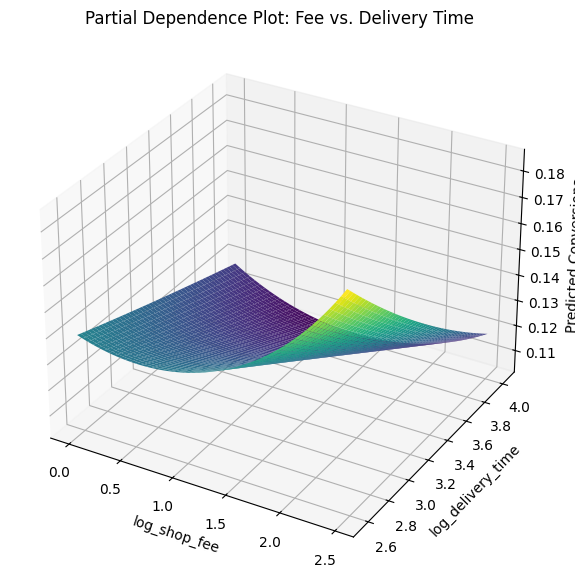

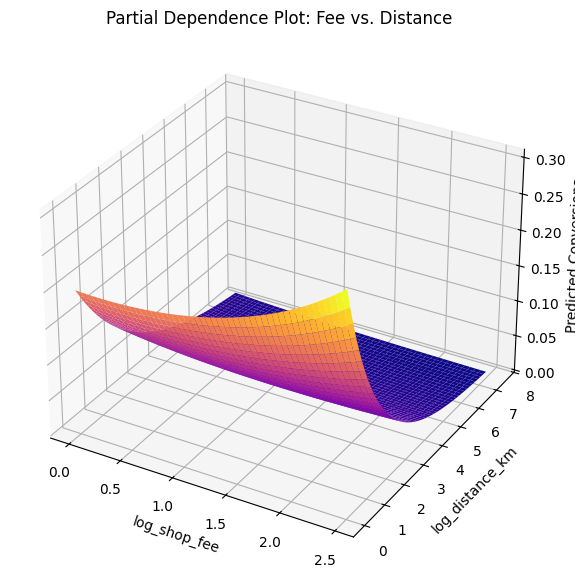

In [311]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Generate a grid of values for fee, delivery time, and distance
log_shop_fee_range = np.linspace(df_session["log_shop_fee"].min(), df_session["log_shop_fee"].max(), 50)
log_delivery_time_range = np.linspace(df_session["log_delivery_time"].min(), df_session["log_delivery_time"].max(), 50)
log_distance_km_range = np.linspace(df_session["log_distance_km"].min(), df_session["log_distance_km"].max(), 50)

# Create a mesh grid for 3D visualization
log_shop_fee_grid, log_delivery_time_grid = np.meshgrid(log_shop_fee_range, log_delivery_time_range)
log_distance_km_grid = np.mean(df_session["log_distance_km"])  # Keep distance fixed

# Create a DataFrame for prediction
df_pdp_fee_time = pd.DataFrame({
    "log_shop_fee": log_shop_fee_grid.ravel(),
    "log_shop_fee_sq": log_shop_fee_grid.ravel() ** 2,
    "log_delivery_time": log_delivery_time_grid.ravel(),
    "log_distance_km": log_distance_km_grid,
    "log_fee_x_time": (log_shop_fee_grid * log_delivery_time_grid).ravel(),
    "log_fee_x_distance": (log_shop_fee_grid * log_distance_km_grid).ravel(),
})

# Predict conversions
predicted_conversions_fee_time = model_with_interactions.predict(df_pdp_fee_time).values.reshape(log_shop_fee_grid.shape)

# 3D Plot: Fee vs. Delivery Time
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(log_shop_fee_grid, log_delivery_time_grid, predicted_conversions_fee_time, cmap="viridis")

ax.set_xlabel("log_shop_fee")
ax.set_ylabel("log_delivery_time")
ax.set_zlabel("Predicted Conversions")
ax.set_title("Partial Dependence Plot: Fee vs. Delivery Time")

plt.show()

# Now create a grid for Fee vs. Distance
log_shop_fee_grid, log_distance_km_grid = np.meshgrid(log_shop_fee_range, log_distance_km_range)
log_delivery_time_grid = np.mean(df_session["log_delivery_time"])  # Keep delivery time fixed

df_pdp_fee_distance = pd.DataFrame({
    "log_shop_fee": log_shop_fee_grid.ravel(),
    "log_shop_fee_sq": log_shop_fee_grid.ravel() ** 2,
    "log_delivery_time": log_delivery_time_grid,
    "log_distance_km": log_distance_km_grid.ravel(),
    "log_fee_x_time": (log_shop_fee_grid * log_delivery_time_grid).ravel(),
    "log_fee_x_distance": (log_shop_fee_grid * log_distance_km_grid).ravel(),
})

# Predict conversions
predicted_conversions_fee_distance = model_with_interactions.predict(df_pdp_fee_distance).values.reshape(log_shop_fee_grid.shape)

# 3D Plot: Fee vs. Distance
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(log_shop_fee_grid, log_distance_km_grid, predicted_conversions_fee_distance, cmap="plasma")

ax.set_xlabel("log_shop_fee")
ax.set_ylabel("log_distance_km")
ax.set_zlabel("Predicted Conversions")
ax.set_title("Partial Dependence Plot: Fee vs. Distance")

plt.show()


In [195]:
# Define distance groups
listings_df['distance_group'] = pd.cut(listings_df['distance_km'], bins=[0, 2, 5, 10, 20], labels=["0-2km", "2-5km", "5-10km", "10-20km"])

# Run separate regressions for each distance group
for group in listings_df['distance_group'].unique():
    subset = listings_df[listings_df['distance_group'] == group]
    subset = subset.dropna(subset=['shopDeliveryFee', 'average_delivery_time', 'click'])


    X = subset[['shopDeliveryFee', 'average_delivery_time']]
    X = sm.add_constant(X)
    y = subset['click']
    
    model = sm.OLS(y, X).fit()
    
    print(f"Regression results for distance group: {group}")
    print(model.summary())
    print("\n" + "-"*80 + "\n")


Regression results for distance group: 2-5km
                            OLS Regression Results                            
Dep. Variable:                  click   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     324.1
Date:                Sat, 15 Mar 2025   Prob (F-statistic):          2.04e-141
Time:                        00:31:13   Log-Likelihood:            -2.1984e+05
No. Observations:              871423   AIC:                         4.397e+05
Df Residuals:                  871420   BIC:                         4.397e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

ValueError: zero-size array to reduction operation maximum which has no identity

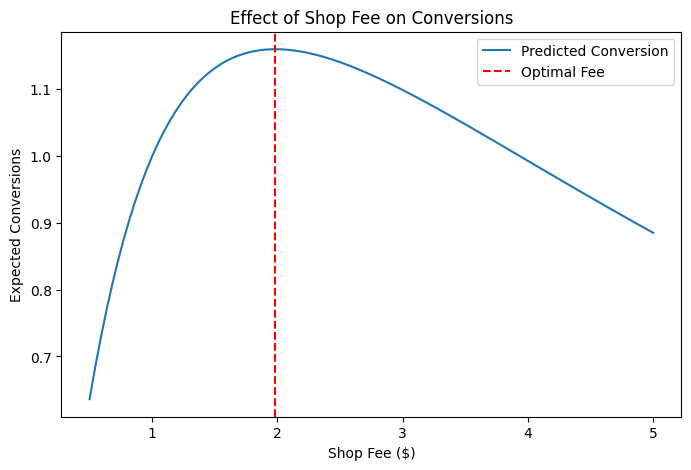

In [136]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate values for shop fee
shop_fees = np.linspace(0.5, 5, 100)  # Adjust range based on your data
log_shop_fees = np.log(shop_fees)

# Compute predicted effect
predicted_conversion = 0.4336 * log_shop_fees - 0.3165 * (log_shop_fees ** 2)

# Plot
plt.figure(figsize=(8,5))
plt.plot(shop_fees, np.exp(predicted_conversion), label="Predicted Conversion")
plt.axvline(x=np.exp(0.685), color='r', linestyle="--", label="Optimal Fee")
plt.xlabel("Shop Fee ($)")
plt.ylabel("Expected Conversions")
plt.title("Effect of Shop Fee on Conversions")
plt.legend()
plt.show()


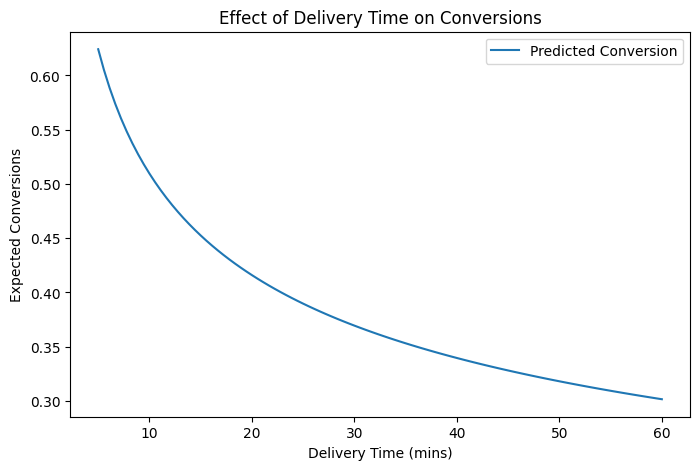

In [137]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate values for delivery time
delivery_times = np.linspace(5, 60, 100)  # Adjust range based on your data
log_delivery_times = np.log(delivery_times)

# Compute predicted effect using coefficient from model
predicted_conversion = -0.2928 * log_delivery_times  # No quadratic term

# Plot
plt.figure(figsize=(8,5))
plt.plot(delivery_times, np.exp(predicted_conversion), label="Predicted Conversion")
plt.xlabel("Delivery Time (mins)")
plt.ylabel("Expected Conversions")
plt.title("Effect of Delivery Time on Conversions")
plt.legend()
plt.show()


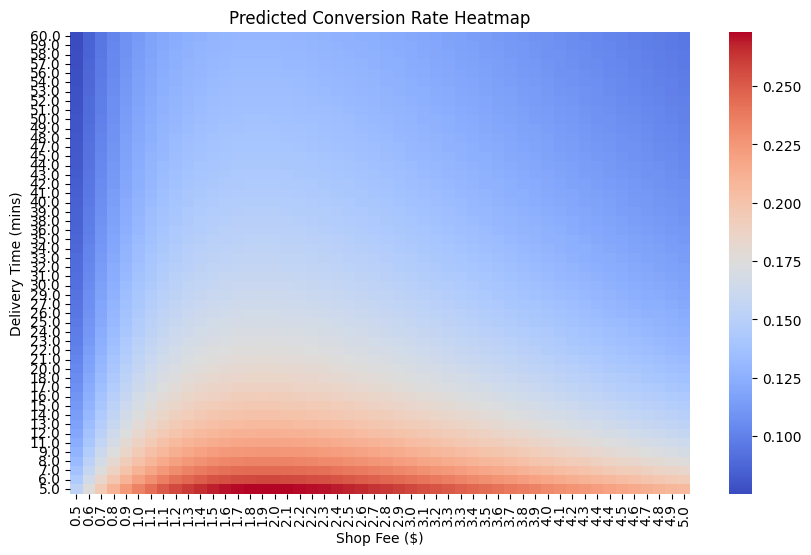

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define ranges for shop fee and delivery time
shop_fees = np.linspace(0.5, 5, 50)  # Adjust range based on your data
delivery_times = np.linspace(5, 60, 50)  # Adjust range based on your data

# Create meshgrid for plotting
shop_fee_grid, delivery_time_grid = np.meshgrid(shop_fees, np.sort(delivery_times))  # Ensure delivery_time is sorted

# Compute log values
log_shop_fee_grid = np.log(shop_fee_grid)
log_delivery_time_grid = np.log(delivery_time_grid)

# Compute predicted log conversion
predicted_log_conversion = (
    -0.9633 + 
    0.4336 * log_shop_fee_grid - 
    0.3165 * (log_shop_fee_grid ** 2) - 
    0.2928 * log_delivery_time_grid - 
    0.0102 * (log_shop_fee_grid * log_delivery_time_grid)
)

# Convert log conversion to actual predicted conversion rates
predicted_conversion = np.exp(predicted_log_conversion)

# Ensure Y-axis (delivery time) is sorted correctly in the heatmap
plt.figure(figsize=(10,6))
ax = sns.heatmap(predicted_conversion, 
                 xticklabels=np.round(shop_fees, 1), 
                 yticklabels=np.round(np.sort(delivery_times), 0),  # Sorted delivery times
                 cmap="coolwarm", 
                 annot=False)

# Invert Y-axis to have lowest delivery time at the bottom (if needed)
ax.invert_yaxis()  

plt.xlabel("Shop Fee ($)")
plt.ylabel("Delivery Time (mins)")
plt.title("Predicted Conversion Rate Heatmap")
plt.show()


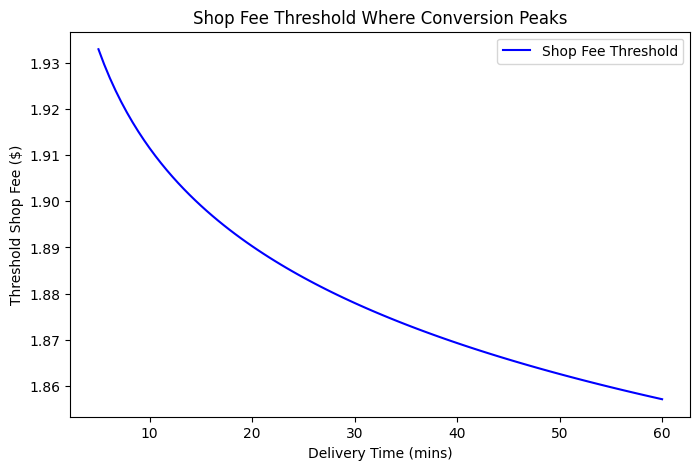

In [140]:
import numpy as np
import matplotlib.pyplot as plt

# Define a range of delivery times
delivery_times = np.linspace(5, 60, 100)  # Adjust range as needed
log_delivery_times = np.log(delivery_times)

# Compute threshold shop fee for each delivery time
threshold_shop_fees = np.exp((0.4336 - 0.0102 * log_delivery_times) / (2 * 0.3165))

# Plot threshold fee vs delivery time
plt.figure(figsize=(8, 5))
plt.plot(delivery_times, threshold_shop_fees, label="Shop Fee Threshold", color="blue")
plt.xlabel("Delivery Time (mins)")
plt.ylabel("Threshold Shop Fee ($)")
plt.title("Shop Fee Threshold Where Conversion Peaks")
plt.legend()
plt.show()

In [52]:
# Aggregate conversion rate by (delivery_time, delivery_fee)
agg_df = listings_df.groupby(['average_delivery_time', 'shopDeliveryFee']).agg(
    conversion_rate=('click', 'sum'),
    total_shops=('shopId', 'count')
).reset_index()

# # Create a grid for interpolation
# grid_x, grid_y = np.meshgrid(
#     np.linspace(agg_df['delivery_time'].min(), agg_df['delivery_time'].max(), 100),
#     np.linspace(agg_df['delivery_fee'].min(), agg_df['delivery_fee'].max(), 100)
# )

# # Interpolate using griddata
# grid_z = griddata(
#     (agg_df['delivery_time'], agg_df['delivery_fee']), 
#     agg_df['conversion_rate'], 
#     (grid_x, grid_y), method='cubic'
# )

# # Apply Gaussian smoothing
# grid_z_smooth = ndimage.gaussian_filter(grid_z, sigma=1.5)

# # Plot the smoothed heatmap
# plt.figure(figsize=(10, 6))
# plt.contourf(grid_x, grid_y, grid_z_smooth, levels=15, cmap='coolwarm')
# plt.colorbar(label='Conversion Rate')
# plt.xlabel("Delivery Time (mins)")
# plt.ylabel("Delivery Fee ($)")
# plt.title("Smoothed Conversion Rate by Delivery Time & Fee")
# plt.show()

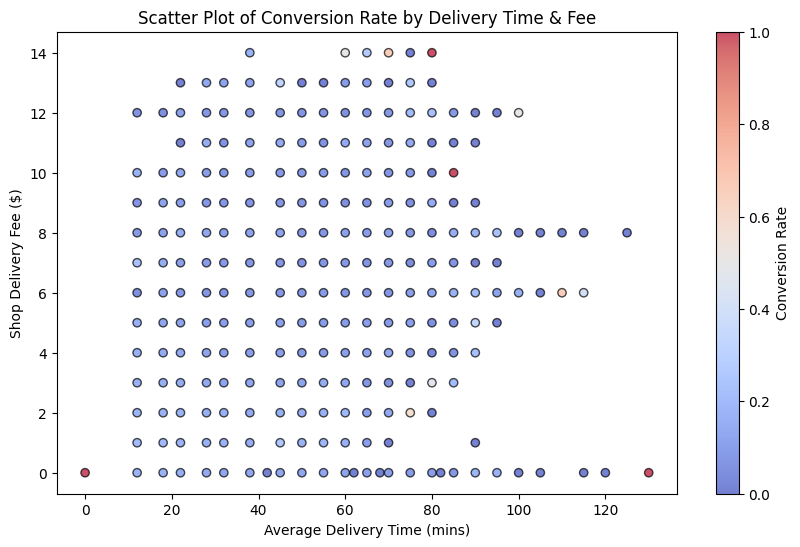

In [53]:

import matplotlib.pyplot as plt
agg_df = agg_df[agg_df['shopDeliveryFee'] < 15]

# Compute conversion rate
agg_df['conversion_rate'] = agg_df['conversion_rate'] / agg_df['total_shops']

# Plot scatter chart of conversion rate by delivery time and delivery fee
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    agg_df['average_delivery_time'], agg_df['shopDeliveryFee'], 
    c=agg_df['conversion_rate'], cmap='coolwarm', alpha=0.7, edgecolors='k'
)
plt.colorbar(scatter, label='Conversion Rate')
plt.xlabel("Average Delivery Time (mins)")
plt.ylabel("Shop Delivery Fee ($)")
plt.title("Scatter Plot of Conversion Rate by Delivery Time & Fee")
plt.show()

In [35]:
agg_df['conversion_rate'] < agg_df['total_shops']

0      False
1      False
2      False
3      False
4      False
       ...  
346    False
347    False
348    False
349    False
350    False
Length: 351, dtype: bool

In [41]:
import pandas as pd
import statsmodels.api as sm

# Aggregate the data at the session level
session_df = listings_df.groupby(['session_key','locationCity']).agg(
    avg_delivery_fee = ('shopDeliveryFee', 'mean'),
    avg_delivery_time = ('average_delivery_time', 'mean'),
    click_rate = ('click', 'mean'),    # proportion of shops clicked per session
    num_exposures = ('session_key', 'count')  # number of shops viewed in the session
).reset_index()

# For log-transformation, add a small constant to avoid log(0)
epsilon = 1e-6
session_df['log_avg_delivery_fee'] = np.log(session_df['avg_delivery_fee'] + epsilon)
session_df['log_avg_delivery_time'] = np.log(session_df['avg_delivery_time'] + epsilon)

print(session_df.head())


# Create dummy variables for locationCity, dropping the first category
location_dummies = pd.get_dummies(session_df['locationCity'], prefix='locationCity', drop_first=True)

# Combine numeric predictors with the dummy variables
X = pd.concat([session_df[['log_avg_delivery_fee', 'log_avg_delivery_time']], location_dummies], axis=1)
X = sm.add_constant(X)  # Adds the intercept term

# Define the dependent variable
y = session_df['click_rate']

# Debug: Print data types before conversion
print("Before conversion, X dtypes:")
print(X.dtypes)
print("\nBefore conversion, y dtype:")
print(y.dtype)

# Convert all columns to numeric, coercing errors to NaN
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Debug: Check data types again
print("\nAfter pd.to_numeric, X dtypes:")
print(X.dtypes)
print("\nAfter pd.to_numeric, y dtype:")
print(y.dtype)

# Force conversion to float if needed
X = X.astype(float)
y = y.astype(float)

# Optionally, drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Debug: Check shapes and dtypes one more time
print("\nFinal X dtypes:")
print(X.dtypes)
print("\nFinal X shape:", X.shape)
print("Final y shape:", y.shape)

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                session_key locationCity  avg_delivery_fee  avg_delivery_time  \
0  +++b0H7fIGqLENadjkvesQ==        Rauma          5.000000          18.000000   
1  ++0B4qQM4ms6wCHwK9HqpQ==    Seinäjoki          5.000000          22.000000   
2  ++17LRnS46b9xDXOdMQn/g==     Helsinki          2.181818          18.727273   
3  ++1CcXWGS5BkY/OeswqK4g==         Kemi          2.714286          16.857143   
4  ++1KRKw3b2Q/46I8V8LrXw==     Helsinki          0.000000          22.000000   

   click_rate  num_exposures  log_avg_delivery_fee  log_avg_delivery_time  
0         1.0              1              1.609438               2.890372  
1         1.0              1              1.609438               3.091042  
2         1.0             11              0.780159               2.929981  
3         1.0              7              0.998529               2.824775  
4         1.0              1            -13.815511               3.091042  
Before conversion, X dtypes:
const                       

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [ ]:
import statsmodels.api as sm

# Define the formula: add additional covariates as needed.
formula = "click ~ log_delivery_fee + log_promised_time"

# Fit a GEE model clustering on session_id
gee_model = sm.GEE.from_formula(formula,
                                groups="session_key",
                                data=listings_df,
                                family=sm.families.Binomial())
gee_result = gee_model.fit()

print(gee_result.summary())

In [ ]:
# Create design matrices for fixed effects using patsy.
formula = "click ~ log_delivery_fee + log_promised_time"
y, X = patsy.dmatrices(formula, data, return_type='dataframe')

# Create a variance components design matrix for the random intercept by session.
vc_formula = "0 + C(session_key)"
vc_matrix = patsy.dmatrix(vc_formula, data, return_type='dataframe')
vc = {"session": vc_matrix}

# Fit the BinomialBayesMixedGLM model using variational Bayes
model = BinomialBayesMixedGLM(endog=y, exog=X, exog_vc=vc)
fit_result = model.fit_vb()

print(fit_result.summary())